# Wolverton Watershed

In [1]:
watershed = 'Wolverton'

In [2]:
%matplotlib inline
import pandas as pd
import numpy as np
import datetime as dt
import copy
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
# some_file.py
#import sys
# insert at 1, 0 is the script path (or '' in REPL)
#sys.path.insert(1, '/Volumes/GoogleDrive/My Drive/DataReleasePaper/ReleaseData/Functions')
#import Abnormal_data_values_control 
#from Abnormal_data_values_control import threC
import os
os.getcwd()
os.getcwd().rsplit('/',1)[0]

'/Volumes/GoogleDrive/My Drive/DataReleasePaper/ReleaseData/27-Sierra/27.4-Wolverton'

In [67]:
def nan_groupby(df, method = 'mean', ratio = 0.1): # 0.1*24=2.4 allow 2 hourly missing data points within 24h (one day)
    groupby_df = pd.DataFrame(columns = df.columns)
    for col in df.columns: 
        df_col = df[[col]]
        for group, data in df_col.groupby(df_col.index.date):
            na_rows = data.shape[0] - data.count()[0]
            total_rows = data.shape[0]
            na_ratio = na_rows/total_rows
            if method == 'mean':
                if 0<na_ratio<ratio: # don't want to waste data in this case
                    data[col] = pd.to_numeric(data[col], errors='coerce')
                    groupby_df.loc[group,col] = data.mean().values[0]
                    print([col,group])
                    print("nan ratio is",na_ratio,", groupby value is", data.mean().values[0])
                else:
                    data[col] = pd.to_numeric(data[col], errors='coerce')
                    groupby_df.loc[group,col] = data.mean(skipna = False).values[0]     
            if method == 'sum':
                if 0<na_ratio<ratio: # don't want to waste data case
                    data[col] = pd.to_numeric(data[col], errors='coerce')
                    groupby_df.loc[group,col] = (data.sum().values[0])/(1-na_ratio) # standardize the value
                    print([col,group])
                    print("nan ratio is",na_ratio,", groupby value is", (data.sum().values[0])/(1-na_ratio))
                else:
                    data[col] = pd.to_numeric(data[col], errors='coerce')
                    groupby_df.loc[group,col] = data.sum(skipna = False).values[0]                
    return groupby_df

# function for aggregation(daily) and combination
def aggre_and_comb_daily(lst, axis=1, func = "sum"):
    prep = pd.DataFrame()
    for df in lst:
        if axis == 1:
            if func == "sum":
                prep = prep.join(nan_groupby(df,method = func),how ='outer')
            elif func == "mean":
                prep = prep.join(nan_groupby(df,method = func),how ='outer')        
        elif axis == 0: # concatenate by year
            if func == "sum":
                prep = pd.concat([prep,nan_groupby(df,method = func)], axis = 0)
            elif func == "mean":
                prep = pd.concat([prep,nan_groupby(df,method = func)], axis = 0)
            prep.index.rename('DateTime', inplace = True)
        prep = prep[prep.index.notnull()]
    print('The final table is:')
    display(prep.head(2))
    display(prep.tail(2))
    prep.index = pd.to_datetime(prep.index,errors = 'coerce')
    return prep

# a case-by-case function where the threshold values could be changed according with different watersheds
def threC(prep,varname):
# This function returns a dataframe without unrealistic values
# This function only deletes unrealistic data, doesn't deal with the outliers
# SR avg is 1361 W/m2 for earth, could be net solar radiation so include negative values  
    thre_dic = {'Discharge':(0,9999999),  # comment here is the threshold values are changed for this case
                'Precipitation':(0,9999), 
                'AirTemperature':(-20,50),
                'SolarRadiation':(-50,1361),
                'RelativeHumidity': (0,100), 
                'WindDirection': (0,365),
                'WindSpeed': (0, 99),
                'SWE': (0,9999),
                'SnowDepth': (0,9999),
                'VaporPressure': (0,101), 
                'SoilMoisture': (0,100),
                'SoilTemperature': (-5,25), #######
                'Isotope': (-9999,9999), 
                'DewPointTemperature': (-100,100), 
                'Snowmelt': (0,9999)
                 }
    thmin = thre_dic[varname][0]
    thmax = thre_dic[varname][1]    
    for i in range(len(prep.columns)):
        col = prep.columns[i]     
        # tranfer the values to be numeric 
        prep[col] = np.array(pd.to_numeric(prep[col], errors='coerce'))        
        prep.iloc[np.ravel(np.argwhere(np.array(prep[col]) < thmin)),i] = np.nan
        if np.ravel(np.argwhere(np.array(prep[col]) < thmin)).shape[0]!=0:     
            print(col,'Out of lower threshold indexes:', np.ravel(np.argwhere(np.array(prep[col]) < thmin)))
            print(col,'Out of lower threshold number:', np.ravel(np.argwhere(np.array(prep[col]) < thmin)).shape[0])        
        prep.iloc[np.ravel(np.argwhere(np.array(prep[col]) > thmax)),i] = np.nan
        if np.ravel(np.argwhere(np.array(prep[col]) >thmax)).shape[0]!=0:
            print(col,'Out of upper threshold indexes:', np.ravel(np.argwhere(np.array(prep[col]) > thmax)))
            print(col,'Out of upper threshold number:', np.ravel(np.argwhere(np.array(prep[col]) > thmax)).shape[0])            
    return prep

### 1. Streamflow

In [4]:
# 1. USGS 11208730 EF KAWEAH R NR THREE RIVERS CA
data = pd.read_csv('https://waterdata.usgs.gov/nwis/dv?cb_00060=on&format=rdb&site_no=11208730&referred_module=sw&period=&begin_date=2005-10-01&end_date=2017-09-30',
                   header = 0, skiprows=27,sep = '\t')
display(data.head(2))

agency_cd   site_no    datetime 213559_00060_00003 213559_00060_00003_cd
0        5s       15s         20d                14n                   10s
1      USGS  11208730  2005-10-01               11.0                     A

In [5]:
prep = copy.deepcopy(data.drop([0]))
prep.index = prep['datetime']
prep = copy.deepcopy(pd.DataFrame(pd.to_numeric(prep['213559_00060_00003'])* 28.3168))
prep.columns = ['ThreeRivers_Discharge']
prep = threC(prep,'Discharge')
display(prep.head(3))
prep.tail(3)
prep1 = copy.deepcopy(prep)

ThreeRivers_Discharge
datetime                         
2005-10-01               311.4848
2005-10-02               283.1680
2005-10-03               283.1680

In [6]:
# 2. USGS 11208600 KAWEAH R BL CONDUIT NO. 2 NR HAMMOND CA
data = pd.read_csv('https://waterdata.usgs.gov/nwis/dv?cb_00060=on&format=rdb&site_no=11208600&referred_module=sw&period=&begin_date=2005-10-01&end_date=2017-09-30',
                    header = 0, skiprows=27,sep = '\t')
display(data.head(2))


agency_cd   site_no    datetime 213551_00060_00003 213551_00060_00003_cd
0        5s       15s         20d                14n                   10s
1      USGS  11208600  2005-10-01               13.0                     A

In [7]:
prep = copy.deepcopy(data.drop([0]))
prep.index = prep['datetime']
prep = copy.deepcopy(pd.DataFrame(pd.to_numeric(prep['213551_00060_00003'])* 28.3168))
prep.columns = ['Hammond_Discharge']
prep = threC(prep,'Discharge')
display(prep.head(3))
prep.tail(3)
prep2 = copy.deepcopy(prep)

Hammond_Discharge
datetime                     
2005-10-01           368.1184
2005-10-02           368.1184
2005-10-03           368.1184

In [10]:
# 3. USGS 11206820 MARBLE FORK KAWEAH R AB HORSE C NR LODGEPOLE CA
data = pd.read_csv('https://waterdata.usgs.gov/nwis/dv?cb_00060=on&format=rdb&site_no=11206820&referred_module=sw&period=&begin_date=2005-10-01&end_date=2017-09-30',
  header = 0, skiprows=27,sep = '\t')
display(data.head(2))

agency_cd   site_no    datetime 9226_00060_00003 9226_00060_00003_cd
0        5s       15s         20d              14n                 10s
1      USGS  11206820  2013-10-01             0.07                   A

In [11]:
prep = copy.deepcopy(data.drop([0]))
prep.index = prep['datetime']
prep = pd.DataFrame(pd.to_numeric(prep['9226_00060_00003'])* 28.3168)
prep.columns = ['LodgePole_Discharge']
prep = threC(prep,'Discharge')
display(prep.head(3))
prep.tail(3)
prep3 = copy.deepcopy(prep)

LodgePole_Discharge
datetime                       
2013-10-01             1.982176
2013-10-02             1.982176
2013-10-03             1.982176

In [13]:
df_lst=[prep1,prep2,prep3]
for df in df_lst:
    df.index=pd.to_datetime(df.index)
prep = aggre_and_comb_daily(df_lst, axis=1, func = "mean") 

The final table is:


ThreeRivers_Discharge Hammond_Discharge LodgePole_Discharge
2005-10-01               311.485           368.118                 NaN
2005-10-02               283.168           368.118                 NaN

ThreeRivers_Discharge Hammond_Discharge LodgePole_Discharge
2017-09-29               594.653           509.702             44.4574
2017-09-30               566.336           538.019             39.0772

ThreeRivers_Discharge
Hammond_Discharge
LodgePole_Discharge


ThreeRivers_Discharge  Hammond_Discharge  LodgePole_Discharge
2005-10-01              311.48480           368.1184                  NaN
2005-10-02              283.16800           368.1184                  NaN
2005-10-03              283.16800           368.1184                  NaN
2005-10-04              280.33632           368.1184                  NaN
2005-10-05              277.50464           368.1184                  NaN

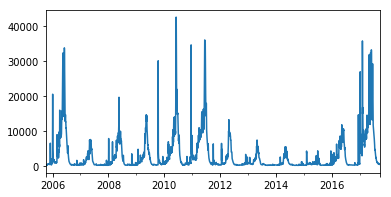

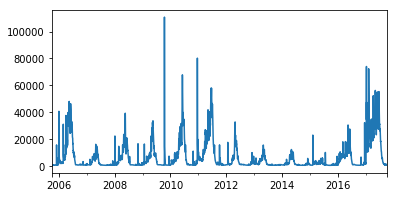

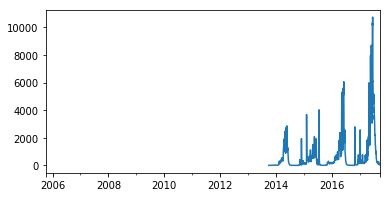

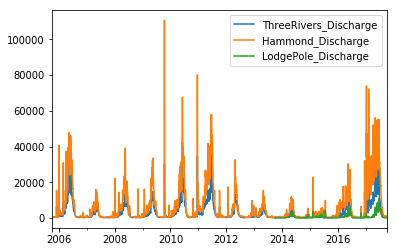

In [14]:
indexUnique = pd.date_range(str(prep.index[0]), str(prep.index[-1]))  
ready_columns = pd.unique(prep.columns)  
siteList = ready_columns
nan_values = np.nan*np.ones([len(indexUnique),len(ready_columns)])
df = pd.DataFrame(nan_values, index=indexUnique, columns = ready_columns) 
for i in np.arange(len(ready_columns)):  
    print(siteList[i])            
    site = siteList[i]     
    tab = prep[site]
    for j in np.arange(len(prep)):  
        df.loc[tab.index[j]][ready_columns[i]] = tab[j]  
    plt.figure(figsize=(6,3))
    df[site].plot()
Discharge = copy.deepcopy(df)
Discharge.plot()
Discharge.head()

### Meteorology Variables

### 2. Precipitation

In [19]:
linklist_Panther = ['https://eng.ucmerced.edu/snsjho/files/MHWG/Field/SEKI/Wolverton/Panther_Met_Station/level_1/WaterYear_2005_2006_Panther_Met_Station.csv',
                    'https://eng.ucmerced.edu/snsjho/files/MHWG/Field/SEKI/Wolverton/Panther_Met_Station/level_1/WaterYear_2006_2007_Panther_Met_Station.csv',
                    'https://eng.ucmerced.edu/snsjho/files/MHWG/Field/SEKI/Wolverton/Panther_Met_Station/level_1/WaterYear_2007_2008_Panther_Met_Station.csv',
                    'https://eng.ucmerced.edu/snsjho/files/MHWG/Field/SEKI/Wolverton/Panther_Met_Station/level_1/WaterYear_2008_2009_Panther_Met_Station.csv',
                    'https://eng.ucmerced.edu/snsjho/files/MHWG/Field/SEKI/Wolverton/Panther_Met_Station/level_1/WaterYear_2009_2010_Panther_Met_Station.csv',
                    'https://eng.ucmerced.edu/snsjho/files/MHWG/Field/SEKI/Wolverton/Panther_Met_Station/level_1/WaterYear_2010_2011_Panther_Met_Station.csv',
                    'https://eng.ucmerced.edu/snsjho/files/MHWG/Field/SEKI/Wolverton/Panther_Met_Station/level_1/WaterYear_2011_2012_Panther_Met_Station.csv',
                    'https://eng.ucmerced.edu/snsjho/files/MHWG/Field/SEKI/Wolverton/Panther_Met_Station/level_1/WaterYear_2012_2013_Panther_Met_Station.csv',
                    'https://eng.ucmerced.edu/snsjho/files/MHWG/Field/SEKI/Wolverton/Panther_Met_Station/level_1/WaterYear_2013_2014_Panther_Met_Station.csv',
                    'https://eng.ucmerced.edu/snsjho/files/MHWG/Field/SEKI/Wolverton/Panther_Met_Station/level_1/WaterYear_2014_2015_Panther_Met_Station.csv',
                    'https://eng.ucmerced.edu/snsjho/files/MHWG/Field/SEKI/Wolverton/Panther_Met_Station/level_1/WaterYear_2015_2016_Panther_Met_Station.csv',
                    'https://eng.ucmerced.edu/snsjho/files/MHWG/Field/SEKI/Wolverton/Panther_Met_Station/level_1/WaterYear_2016_2017_Panther_Met_Station.csv']
df_lst=[]
for i in range(len(linklist_Panther)):
    link = linklist_Panther[i]
    print(2005 + i)
    data = pd.read_csv(link,index_col = "TIMESTAMP",parse_dates = True, infer_datetime_format = True, header = 0)  
    var = pd.DataFrame(pd.to_numeric(data['Rain_mm_Tot'],errors = 'coerce'))
    var.columns = ['Panther_Precipitation']
    var = threC(var,'Precipitation')
    var.index = pd.to_datetime(var.index)
    display(var.head(2))
    df_lst.append(var)
prep1=aggre_and_comb_daily(df_lst, axis=0, func = "sum") 

2005


Panther_Precipitation
TIMESTAMP                                 
2005-10-01 00:00:00                    NaN
2005-10-01 01:00:00                    NaN

2006


Panther_Precipitation
TIMESTAMP                                 
2006-10-01 00:00:00                    NaN
2006-10-01 01:00:00                    NaN

2007


Panther_Precipitation
TIMESTAMP                                 
2007-10-01 00:00:00                    0.0
2007-10-01 01:00:00                    0.0

2008


Panther_Precipitation
TIMESTAMP                                 
2008-10-01 00:00:00                    0.1
2008-10-01 01:00:00                    0.0

2009


Panther_Precipitation
TIMESTAMP                                 
2009-10-01 00:00:00                    0.0
2009-10-01 01:00:00                    0.0

2010


Panther_Precipitation
TIMESTAMP                                 
2010-10-01 00:00:00                    0.0
2010-10-01 01:00:00                    0.0

2011


Panther_Precipitation
TIMESTAMP                                 
2011-10-01 00:00:00                    0.0
2011-10-01 01:00:00                    0.0

2012


Panther_Precipitation
TIMESTAMP                                 
2012-10-01 00:00:00                    0.0
2012-10-01 01:00:00                    0.0

2013


Panther_Precipitation
TIMESTAMP                                 
2013-10-01 00:00:00                    0.0
2013-10-01 01:00:00                    0.0

2014


Panther_Precipitation
TIMESTAMP                                 
2014-10-01 00:00:00                    0.0
2014-10-01 01:00:00                    0.0

2015


Panther_Precipitation
TIMESTAMP                                 
2015-10-01 00:00:00                    0.0
2015-10-01 01:00:00                    0.0

2016


Panther_Precipitation
TIMESTAMP                                 
2016-10-01 00:00:00                    0.0
2016-10-01 01:00:00                    0.0

['Panther_Precipitation', datetime.date(2008, 1, 13)]
nan ratio is 0.08333333333333333 , groupby value is 0.0
['Panther_Precipitation', datetime.date(2009, 5, 25)]
nan ratio is 0.041666666666666664 , groupby value is 0.0
['Panther_Precipitation', datetime.date(2016, 10, 13)]
nan ratio is 0.08333333333333333 , groupby value is 0.0
The final table is:


Panther_Precipitation
DateTime                        
2005-10-01                   NaN
2005-10-02                   NaN

Panther_Precipitation
DateTime                        
2017-09-29                   NaN
2017-09-30                   NaN

In [20]:
linklist_Wolverton = ['https://eng.ucmerced.edu/snsjho/files/MHWG/Field/SEKI/Wolverton/Wolverton_Met_Station/level_1/WaterYear_2005_2006_Wolverton_Met_Station.csv',
                      'https://eng.ucmerced.edu/snsjho/files/MHWG/Field/SEKI/Wolverton/Wolverton_Met_Station/level_1/WaterYear_2006_2007_Wolverton_Met_Station.csv',
                     'https://eng.ucmerced.edu/snsjho/files/MHWG/Field/SEKI/Wolverton/Wolverton_Met_Station/level_1/WaterYear_2007_2008_Wolverton_Met_Station.csv',
                     'https://eng.ucmerced.edu/snsjho/files/MHWG/Field/SEKI/Wolverton/Wolverton_Met_Station/level_1/WaterYear_2008_2009_Wolverton_Met_Station.csv',
                     'https://eng.ucmerced.edu/snsjho/files/MHWG/Field/SEKI/Wolverton/Wolverton_Met_Station/level_1/WaterYear_2009_2010_Wolverton_Met_Station.csv',
                     'https://eng.ucmerced.edu/snsjho/files/MHWG/Field/SEKI/Wolverton/Wolverton_Met_Station/level_1/WaterYear_2010_2011_Wolverton_Met_Station.csv',
                     'https://eng.ucmerced.edu/snsjho/files/MHWG/Field/SEKI/Wolverton/Wolverton_Met_Station/level_1/WaterYear_2011_2012_Wolverton_Met_Station.csv',
                     'https://eng.ucmerced.edu/snsjho/files/MHWG/Field/SEKI/Wolverton/Wolverton_Met_Station/level_1/WaterYear_2012_2013_Wolverton_Met_Station.csv',
                     'https://eng.ucmerced.edu/snsjho/files/MHWG/Field/SEKI/Wolverton/Wolverton_Met_Station/level_1/WaterYear_2013_2014_Wolverton_Met_Station.csv',
                     'https://eng.ucmerced.edu/snsjho/files/MHWG/Field/SEKI/Wolverton/Wolverton_Met_Station/level_1/WaterYear_2014_2015_Wolverton_Met_Station.csv',
                     'https://eng.ucmerced.edu/snsjho/files/MHWG/Field/SEKI/Wolverton/Wolverton_Met_Station/level_1/WaterYear_2015_2016_Wolverton_Met_Station.csv',
                     'https://eng.ucmerced.edu/snsjho/files/MHWG/Field/SEKI/Wolverton/Wolverton_Met_Station/level_1/WaterYear_2016_2017_Wolverton_Met_Station.csv']
df_lst=[]
for i in range(len(linklist_Wolverton)):
    link = linklist_Wolverton[i]
    print(2005 + i)
    data = pd.read_csv(link,index_col = "TIMESTAMP",parse_dates = True, infer_datetime_format = True, header = 0)  
    var = pd.DataFrame(pd.to_numeric(data['Rain_mm_Tot'],errors = 'coerce'))
    var.columns = ['Wolverton_Precipitation']
    var = threC(var,'Precipitation')
    var.index = pd.to_datetime(var.index)
    display(var.head(2))
    df_lst.append(var)
prep2=aggre_and_comb_daily(df_lst, axis=0, func = "sum") 

2005


Wolverton_Precipitation
TIMESTAMP                                   
2005-10-01 00:00:00                      NaN
2005-10-01 01:00:00                      NaN

2006


Wolverton_Precipitation
TIMESTAMP                                   
2006-10-01 00:00:00                      NaN
2006-10-01 01:00:00                      NaN

2007


Wolverton_Precipitation
TIMESTAMP                                   
2007-10-01 00:00:00                      NaN
2007-10-01 01:00:00                      NaN

2008


Wolverton_Precipitation
TIMESTAMP                                   
2008-10-01 00:00:00                      0.0
2008-10-01 01:00:00                      0.0

2009


Wolverton_Precipitation
TIMESTAMP                                   
2009-10-01 00:00:00                      0.0
2009-10-01 01:00:00                      0.0

2010


Wolverton_Precipitation
TIMESTAMP                                   
2010-10-01 00:00:00                      0.0
2010-10-01 01:00:00                      0.0

2011


Wolverton_Precipitation
TIMESTAMP                                   
2011-10-01 00:00:00                      0.0
2011-10-01 01:00:00                      0.0

2012


Wolverton_Precipitation
TIMESTAMP                                   
2012-10-01 00:00:00                      0.0
2012-10-01 01:00:00                      0.0

2013


Wolverton_Precipitation
TIMESTAMP                                   
2013-10-01 00:00:00                      0.0
2013-10-01 01:00:00                      0.0

2014


Wolverton_Precipitation
TIMESTAMP                                   
2014-10-01 00:00:00                      0.0
2014-10-01 01:00:00                      0.0

2015


Wolverton_Precipitation
TIMESTAMP                                   
2015-10-01 00:00:00                      0.0
2015-10-01 01:00:00                      0.0

2016


Wolverton_Precipitation
TIMESTAMP                                   
2016-10-01 00:00:00                      0.0
2016-10-01 01:00:00                      0.0

['Wolverton_Precipitation', datetime.date(2008, 1, 13)]
nan ratio is 0.041666666666666664 , groupby value is 0.0
['Wolverton_Precipitation', datetime.date(2009, 5, 24)]
nan ratio is 0.041666666666666664 , groupby value is 0.0
The final table is:


Wolverton_Precipitation
DateTime                          
2005-10-01                     NaN
2005-10-02                     NaN

Wolverton_Precipitation
DateTime                          
2017-09-29                       0
2017-09-30                       0

In [21]:
prep=aggre_and_comb_daily([prep1,prep2], axis=1, func = "sum") 

The final table is:


Panther_Precipitation Wolverton_Precipitation
2005-10-01                   NaN                     NaN
2005-10-02                   NaN                     NaN

Panther_Precipitation Wolverton_Precipitation
2017-09-29                   NaN                       0
2017-09-30                   NaN                       0

Panther_Precipitation
Wolverton_Precipitation


Panther_Precipitation  Wolverton_Precipitation
2005-10-01                    NaN                      NaN
2005-10-02                    NaN                      NaN

<Figure size 720x288 with 0 Axes>

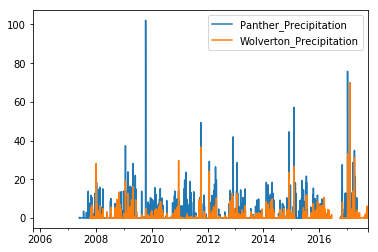

In [22]:
indexUnique = pd.date_range(str(prep.index[0]), str(prep.index[-1])) 
ready_columns = pd.unique(prep.columns)  
siteList = ready_columns
nan_values = np.nan*np.ones([len(indexUnique),len(ready_columns)])
df = pd.DataFrame(nan_values, index=indexUnique, columns = ready_columns) 

plt.figure(figsize=(10,4))
for i in np.arange(len(ready_columns)):  
    print(siteList[i])            
    site = siteList[i]     
    tab = prep[site]

    for j in np.arange(len(prep)):  
        df.loc[tab.index[j]][ready_columns[i]] = tab[j] # 
                       
Precipitation = copy.deepcopy(df)
Precipitation.plot()
Precipitation.head(2)

### 3. AirTemperature

In [23]:
df_lst=[]
for i in range(len(linklist_Panther)):
    link = linklist_Panther[i]
    print(2005 + i)
    data = pd.read_csv(link,index_col = "TIMESTAMP",parse_dates = True, infer_datetime_format = True, header = 0)  
    var = pd.DataFrame(pd.to_numeric(data['AirTC_Avg'],errors = 'coerce'))
    var.columns = ['Panther_AirTemperature']
    var = threC(var,'AirTemperature')
    var.index = pd.to_datetime(var.index)
    display(var.head(2))
    df_lst.append(var)
prep1=aggre_and_comb_daily(df_lst, axis=0, func = "mean") 

2005


Panther_AirTemperature
TIMESTAMP                                  
2005-10-01 00:00:00                     NaN
2005-10-01 01:00:00                     NaN

2006


Panther_AirTemperature
TIMESTAMP                                  
2006-10-01 00:00:00                     NaN
2006-10-01 01:00:00                     NaN

2007


Panther_AirTemperature
TIMESTAMP                                  
2007-10-01 00:00:00                   6.688
2007-10-01 01:00:00                   8.230

2008


Panther_AirTemperature
TIMESTAMP                                  
2008-10-01 00:00:00                   11.41
2008-10-01 01:00:00                   11.20

2009


Panther_AirTemperature
TIMESTAMP                                  
2009-10-01 00:00:00                   5.282
2009-10-01 01:00:00                   5.057

2010


Panther_AirTemperature
TIMESTAMP                                  
2010-10-01 00:00:00                   12.98
2010-10-01 01:00:00                   13.17

2011


Panther_AirTemperature
TIMESTAMP                                  
2011-10-01 00:00:00                   10.14
2011-10-01 01:00:00                    9.52

2012


Panther_AirTemperature
TIMESTAMP                                  
2012-10-01 00:00:00                   12.79
2012-10-01 01:00:00                   13.11

2013


Panther_AirTemperature
TIMESTAMP                                  
2013-10-01 00:00:00                    8.45
2013-10-01 01:00:00                    9.09

2014


Panther_AirTemperature
TIMESTAMP                                  
2014-10-01 00:00:00                   5.316
2014-10-01 01:00:00                   5.391

2015


Panther_AirTemperature
TIMESTAMP                                  
2015-10-01 00:00:00                   11.58
2015-10-01 01:00:00                   10.98

2016


Panther_AirTemperature
TIMESTAMP                                  
2016-10-01 00:00:00                   8.040
2016-10-01 01:00:00                   7.936

['Panther_AirTemperature', datetime.date(2008, 1, 13)]
nan ratio is 0.08333333333333333 , groupby value is 4.092863636363636
['Panther_AirTemperature', datetime.date(2009, 5, 25)]
nan ratio is 0.041666666666666664 , groupby value is 8.942608695652174
['Panther_AirTemperature', datetime.date(2012, 5, 5)]
nan ratio is 0.041666666666666664 , groupby value is 3.496000000000001
['Panther_AirTemperature', datetime.date(2016, 10, 13)]
nan ratio is 0.08333333333333333 , groupby value is 10.4145
The final table is:


Panther_AirTemperature
DateTime                         
2005-10-01                    NaN
2005-10-02                    NaN

Panther_AirTemperature
DateTime                         
2017-09-29                    NaN
2017-09-30                    NaN

In [24]:
df_lst=[]
for i in range(len(linklist_Wolverton)):
    link = linklist_Wolverton[i]
    print(2005 + i)
    data = pd.read_csv(link,index_col = "TIMESTAMP",parse_dates = True, infer_datetime_format = True, header = 0)  
    var = pd.DataFrame(pd.to_numeric(data['AirTC_Avg'],errors = 'coerce'))
    var.columns = ['Wolverton_AirTemperature']
    var = threC(var,'AirTemperature')
    var.index = pd.to_datetime(var.index)
    display(var.head(2))
    df_lst.append(var)
prep2=aggre_and_comb_daily(df_lst, axis=0, func = "mean") 

2005


Wolverton_AirTemperature
TIMESTAMP                                    
2005-10-01 00:00:00                       NaN
2005-10-01 01:00:00                       NaN

2006


Wolverton_AirTemperature
TIMESTAMP                                    
2006-10-01 00:00:00                      8.57
2006-10-01 01:00:00                      8.91

2007


Wolverton_AirTemperature
TIMESTAMP                                    
2007-10-01 00:00:00                     4.262
2007-10-01 01:00:00                     3.875

2008


Wolverton_AirTemperature
TIMESTAMP                                    
2008-10-01 00:00:00                      9.36
2008-10-01 01:00:00                      9.10

2009


Wolverton_AirTemperature
TIMESTAMP                                    
2009-10-01 00:00:00                     1.873
2009-10-01 01:00:00                     1.592

2010


Wolverton_AirTemperature
TIMESTAMP                                    
2010-10-01 00:00:00                     12.38
2010-10-01 01:00:00                     12.19

2011


Wolverton_AirTemperature
TIMESTAMP                                    
2011-10-01 00:00:00                      8.20
2011-10-01 01:00:00                      9.15

2012


Wolverton_AirTemperature
TIMESTAMP                                    
2012-10-01 00:00:00                     10.93
2012-10-01 01:00:00                     10.74

2013


Wolverton_AirTemperature
TIMESTAMP                                    
2013-10-01 00:00:00                     5.435
2013-10-01 01:00:00                     5.560

2014


Wolverton_AirTemperature
TIMESTAMP                                    
2014-10-01 00:00:00                     4.121
2014-10-01 01:00:00                     3.799

2015


Wolverton_AirTemperature
TIMESTAMP                                    
2015-10-01 00:00:00                     10.32
2015-10-01 01:00:00                      9.42

2016


Wolverton_AirTemperature
TIMESTAMP                                    
2016-10-01 00:00:00                     6.395
2016-10-01 01:00:00                     6.062

['Wolverton_AirTemperature', datetime.date(2007, 10, 13)]
nan ratio is 0.08333333333333333 , groupby value is 2.4061363636363633
['Wolverton_AirTemperature', datetime.date(2008, 1, 13)]
nan ratio is 0.041666666666666664 , groupby value is -0.2686521739130437
['Wolverton_AirTemperature', datetime.date(2009, 5, 24)]
nan ratio is 0.041666666666666664 , groupby value is 9.220217391304347
The final table is:


Wolverton_AirTemperature
DateTime                           
2005-10-01                      NaN
2005-10-02                      NaN

Wolverton_AirTemperature
DateTime                           
2017-09-29                  8.99717
2017-09-30                  7.95092

In [25]:
prep=aggre_and_comb_daily([prep1,prep2], axis=1, func = "mean") 

The final table is:


Panther_AirTemperature Wolverton_AirTemperature
2005-10-01                    NaN                      NaN
2005-10-02                    NaN                      NaN

Panther_AirTemperature Wolverton_AirTemperature
2017-09-29                    NaN                  8.99717
2017-09-30                    NaN                  7.95092

Panther_AirTemperature
Wolverton_AirTemperature


Panther_AirTemperature  Wolverton_AirTemperature
2005-10-01                     NaN                       NaN
2005-10-02                     NaN                       NaN

<Figure size 720x288 with 0 Axes>

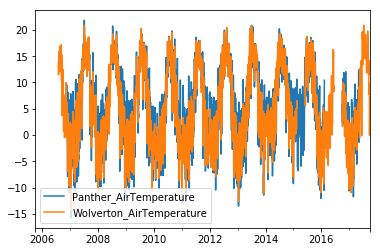

In [26]:
indexUnique = pd.date_range(str(prep.index[0]), str(prep.index[-1]))  
ready_columns = pd.unique(prep.columns)  
siteList = ready_columns
nan_values = np.nan*np.ones([len(indexUnique),len(ready_columns)])
df = pd.DataFrame(nan_values, index=indexUnique, columns = ready_columns) 

plt.figure(figsize=(10,4))
for i in np.arange(len(ready_columns)):  
    print(siteList[i])            
    site = siteList[i]     
    tab = prep[site]

    for j in np.arange(len(prep)):  
        df.loc[tab.index[j]][ready_columns[i]] = tab[j] # 
                       
AirTemperature = copy.deepcopy(df)
AirTemperature.plot()
AirTemperature.head(2)

### 4. SolarRadiation

In [29]:
df_lst=[]
for i in range(len(linklist_Panther)):
    link = linklist_Panther[i]
    print(2005 + i)
    data = pd.read_csv(link,index_col = "TIMESTAMP",parse_dates = True, infer_datetime_format = True, header = 0)  
    var = pd.DataFrame(pd.to_numeric(data['SlrW_Avg'],errors = 'coerce'))
    var.columns = ['Panther_SolarRadiation']
    var = threC(var,'SolarRadiation')
    var.index = pd.to_datetime(var.index)
    display(var.head(2))
    df_lst.append(var)
prep1=aggre_and_comb_daily(df_lst, axis=0, func = "mean") 

2005


Panther_SolarRadiation
TIMESTAMP                                  
2005-10-01 00:00:00                     NaN
2005-10-01 01:00:00                     NaN

2006


Panther_SolarRadiation
TIMESTAMP                                  
2006-10-01 00:00:00                     NaN
2006-10-01 01:00:00                     NaN

2007


Panther_SolarRadiation
TIMESTAMP                                  
2007-10-01 00:00:00                     NaN
2007-10-01 01:00:00                     NaN

2008


Panther_SolarRadiation
TIMESTAMP                                  
2008-10-01 00:00:00                     0.0
2008-10-01 01:00:00                     0.0

2009


Panther_SolarRadiation
TIMESTAMP                                  
2009-10-01 00:00:00                     0.0
2009-10-01 01:00:00                     0.0

2010


Panther_SolarRadiation
TIMESTAMP                                  
2010-10-01 00:00:00                     0.0
2010-10-01 01:00:00                     0.0

2011


Panther_SolarRadiation
TIMESTAMP                                  
2011-10-01 00:00:00                     0.0
2011-10-01 01:00:00                     0.0

2012


Panther_SolarRadiation
TIMESTAMP                                  
2012-10-01 00:00:00                     0.0
2012-10-01 01:00:00                     0.0

2013


Panther_SolarRadiation
TIMESTAMP                                  
2013-10-01 00:00:00                     0.0
2013-10-01 01:00:00                     0.0

2014


Panther_SolarRadiation
TIMESTAMP                                  
2014-10-01 00:00:00                     0.0
2014-10-01 01:00:00                     0.0

2015


Panther_SolarRadiation
TIMESTAMP                                  
2015-10-01 00:00:00                     0.0
2015-10-01 01:00:00                     0.0

2016


Panther_SolarRadiation
TIMESTAMP                                  
2016-10-01 00:00:00                     0.0
2016-10-01 01:00:00                     0.0

['Panther_SolarRadiation', datetime.date(2008, 1, 14)]
nan ratio is 0.08333333333333333 , groupby value is 0.509590909090909
['Panther_SolarRadiation', datetime.date(2008, 1, 15)]
nan ratio is 0.08333333333333333 , groupby value is 0.5428636363636363
['Panther_SolarRadiation', datetime.date(2008, 1, 16)]
nan ratio is 0.08333333333333333 , groupby value is 0.5426818181818182
['Panther_SolarRadiation', datetime.date(2008, 1, 27)]
nan ratio is 0.041666666666666664 , groupby value is 0.2596521739130435
['Panther_SolarRadiation', datetime.date(2008, 1, 30)]
nan ratio is 0.08333333333333333 , groupby value is 0.33122727272727276
['Panther_SolarRadiation', datetime.date(2008, 2, 1)]
nan ratio is 0.041666666666666664 , groupby value is 0.32408695652173913
['Panther_SolarRadiation', datetime.date(2008, 2, 10)]
nan ratio is 0.08333333333333333 , groupby value is 0.6127272727272728
['Panther_SolarRadiation', datetime.date(2008, 11, 5)]
nan ratio is 0.041666666666666664 , groupby value is 0.455391

['Panther_SolarRadiation', datetime.date(2011, 1, 12)]
nan ratio is 0.08333333333333333 , groupby value is 0.5340454545454546
['Panther_SolarRadiation', datetime.date(2011, 1, 13)]
nan ratio is 0.041666666666666664 , groupby value is 0.6399565217391304
['Panther_SolarRadiation', datetime.date(2011, 1, 14)]
nan ratio is 0.041666666666666664 , groupby value is 0.6416956521739131
['Panther_SolarRadiation', datetime.date(2011, 2, 19)]
nan ratio is 0.041666666666666664 , groupby value is 0.4091304347826087
['Panther_SolarRadiation', datetime.date(2011, 3, 2)]
nan ratio is 0.041666666666666664 , groupby value is 0.4071739130434783
['Panther_SolarRadiation', datetime.date(2011, 5, 16)]
nan ratio is 0.041666666666666664 , groupby value is 0.9022608695652174
['Panther_SolarRadiation', datetime.date(2011, 9, 11)]
nan ratio is 0.08333333333333333 , groupby value is 0.4536363636363637
['Panther_SolarRadiation', datetime.date(2011, 10, 4)]
nan ratio is 0.041666666666666664 , groupby value is 0.2783

Panther_SolarRadiation
DateTime                         
2005-10-01                    NaN
2005-10-02                    NaN

Panther_SolarRadiation
DateTime                         
2017-09-29                    NaN
2017-09-30                    NaN

In [30]:
df_lst=[]
for i in range(len(linklist_Wolverton)):
    link = linklist_Wolverton[i]
    print(2005 + i)
    data = pd.read_csv(link,index_col = "TIMESTAMP",parse_dates = True, infer_datetime_format = True, header = 0)  
    var = pd.DataFrame(pd.to_numeric(data['SlrW_Avg'],errors = 'coerce'))
    var.columns = ['Wolverton_SolarRadiation']
    var = threC(var,'SolarRadiation')
    var.index = pd.to_datetime(var.index)
    display(var.head(2))
    df_lst.append(var)
prep2=aggre_and_comb_daily(df_lst, axis=0, func = "mean") 

2005


Wolverton_SolarRadiation
TIMESTAMP                                    
2005-10-01 00:00:00                       NaN
2005-10-01 01:00:00                       NaN

2006


Wolverton_SolarRadiation
TIMESTAMP                                    
2006-10-01 00:00:00                       NaN
2006-10-01 01:00:00                       NaN

2007


Wolverton_SolarRadiation
TIMESTAMP                                    
2007-10-01 00:00:00                       NaN
2007-10-01 01:00:00                       NaN

2008


Wolverton_SolarRadiation
TIMESTAMP                                    
2008-10-01 00:00:00                       0.0
2008-10-01 01:00:00                       0.0

2009


Wolverton_SolarRadiation
TIMESTAMP                                    
2009-10-01 00:00:00                       0.0
2009-10-01 01:00:00                       0.0

2010


Wolverton_SolarRadiation
TIMESTAMP                                    
2010-10-01 00:00:00                       0.0
2010-10-01 01:00:00                       0.0

2011


Wolverton_SolarRadiation
TIMESTAMP                                    
2011-10-01 00:00:00                       0.0
2011-10-01 01:00:00                       0.0

2012


Wolverton_SolarRadiation
TIMESTAMP                                    
2012-10-01 00:00:00                       0.0
2012-10-01 01:00:00                       0.0

2013


Wolverton_SolarRadiation
TIMESTAMP                                    
2013-10-01 00:00:00                     0.000
2013-10-01 01:00:00                     0.001

2014


Wolverton_SolarRadiation
TIMESTAMP                                    
2014-10-01 00:00:00                       0.0
2014-10-01 01:00:00                       0.0

2015


Wolverton_SolarRadiation
TIMESTAMP                                    
2015-10-01 00:00:00                       0.0
2015-10-01 01:00:00                       0.0

2016


Wolverton_SolarRadiation
TIMESTAMP                                    
2016-10-01 00:00:00                       0.0
2016-10-01 01:00:00                       0.0

['Wolverton_SolarRadiation', datetime.date(2008, 1, 13)]
nan ratio is 0.041666666666666664 , groupby value is 7.239043478260869
['Wolverton_SolarRadiation', datetime.date(2008, 2, 27)]
nan ratio is 0.041666666666666664 , groupby value is 27.04526086956522
['Wolverton_SolarRadiation', datetime.date(2008, 3, 1)]
nan ratio is 0.041666666666666664 , groupby value is 37.68852173913044
['Wolverton_SolarRadiation', datetime.date(2008, 3, 2)]
nan ratio is 0.041666666666666664 , groupby value is 24.870260869565215
['Wolverton_SolarRadiation', datetime.date(2008, 3, 12)]
nan ratio is 0.041666666666666664 , groupby value is 38.80499999999999
['Wolverton_SolarRadiation', datetime.date(2008, 3, 23)]
nan ratio is 0.041666666666666664 , groupby value is 24.57630434782609
['Wolverton_SolarRadiation', datetime.date(2008, 3, 27)]
nan ratio is 0.041666666666666664 , groupby value is 34.04404347826086
['Wolverton_SolarRadiation', datetime.date(2008, 3, 28)]
nan ratio is 0.041666666666666664 , groupby valu

['Wolverton_SolarRadiation', datetime.date(2011, 2, 14)]
nan ratio is 0.041666666666666664 , groupby value is 23.399391304347823
['Wolverton_SolarRadiation', datetime.date(2011, 3, 4)]
nan ratio is 0.08333333333333333 , groupby value is 17.899136363636362
['Wolverton_SolarRadiation', datetime.date(2011, 3, 10)]
nan ratio is 0.041666666666666664 , groupby value is 25.233130434782606
['Wolverton_SolarRadiation', datetime.date(2011, 3, 12)]
nan ratio is 0.041666666666666664 , groupby value is 26.922739130434785
['Wolverton_SolarRadiation', datetime.date(2011, 3, 15)]
nan ratio is 0.08333333333333333 , groupby value is 32.39690909090909
['Wolverton_SolarRadiation', datetime.date(2011, 3, 17)]
nan ratio is 0.08333333333333333 , groupby value is 28.16972727272727
['Wolverton_SolarRadiation', datetime.date(2011, 3, 25)]
nan ratio is 0.08333333333333333 , groupby value is 30.85968181818182
['Wolverton_SolarRadiation', datetime.date(2011, 3, 27)]
nan ratio is 0.08333333333333333 , groupby value

['Wolverton_SolarRadiation', datetime.date(2012, 9, 11)]
nan ratio is 0.08333333333333333 , groupby value is 19.667772727272727
['Wolverton_SolarRadiation', datetime.date(2012, 9, 12)]
nan ratio is 0.08333333333333333 , groupby value is 19.073090909090908
['Wolverton_SolarRadiation', datetime.date(2012, 9, 13)]
nan ratio is 0.041666666666666664 , groupby value is 21.95860869565217
['Wolverton_SolarRadiation', datetime.date(2012, 9, 14)]
nan ratio is 0.041666666666666664 , groupby value is 19.443913043478258
['Wolverton_SolarRadiation', datetime.date(2012, 9, 15)]
nan ratio is 0.041666666666666664 , groupby value is 18.36486956521739
['Wolverton_SolarRadiation', datetime.date(2012, 9, 16)]
nan ratio is 0.041666666666666664 , groupby value is 23.396652173913047
['Wolverton_SolarRadiation', datetime.date(2012, 9, 17)]
nan ratio is 0.041666666666666664 , groupby value is 17.964565217391307
['Wolverton_SolarRadiation', datetime.date(2012, 9, 18)]
nan ratio is 0.041666666666666664 , groupby 

Wolverton_SolarRadiation
DateTime                           
2005-10-01                      NaN
2005-10-02                      NaN

Wolverton_SolarRadiation
DateTime                           
2017-09-29                  35.1697
2017-09-30                  30.0093

In [31]:
prep = aggre_and_comb_daily([prep1,prep2], axis=1, func = "mean") 

The final table is:


Panther_SolarRadiation Wolverton_SolarRadiation
2005-10-01                    NaN                      NaN
2005-10-02                    NaN                      NaN

Panther_SolarRadiation Wolverton_SolarRadiation
2017-09-29                    NaN                  35.1697
2017-09-30                    NaN                  30.0093

Panther_SolarRadiation
Wolverton_SolarRadiation


Panther_SolarRadiation  Wolverton_SolarRadiation
2005-10-01                     NaN                       NaN
2005-10-02                     NaN                       NaN
2005-10-03                     NaN                       NaN
2005-10-04                     NaN                       NaN
2005-10-05                     NaN                       NaN

<Figure size 720x288 with 0 Axes>

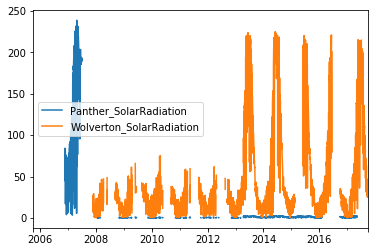

In [32]:
indexUnique = pd.date_range(str(prep.index[0]), str(prep.index[-1]))  
ready_columns = pd.unique(prep.columns)  
siteList = ready_columns
nan_values = np.nan*np.ones([len(indexUnique),len(ready_columns)])
df = pd.DataFrame(nan_values, index=indexUnique, columns = ready_columns) 

plt.figure(figsize=(10,4))
for i in np.arange(len(ready_columns)):  
    print(siteList[i])            
    site = siteList[i]     
    tab = prep[site]

    for j in np.arange(len(prep)):  
        df.loc[tab.index[j]][ready_columns[i]] = tab[j] # 
                       
SolarRadiation = copy.deepcopy(df)
SolarRadiation.plot()
SolarRadiation.head()

### 5. Relative Humidity

In [33]:
df_lst=[]
for i in range(len(linklist_Panther)):
    link = linklist_Panther[i]
    print(2005 + i)
    data = pd.read_csv(link,index_col = "TIMESTAMP",parse_dates = True, infer_datetime_format = True, header = 0)  
    var = pd.DataFrame(pd.to_numeric(data['RH'],errors = 'coerce'))
    var.columns = ['Panther_RelativeHumidity']
    var = threC(var,'RelativeHumidity')
    var.index = pd.to_datetime(var.index)
    display(var.head(2))
    df_lst.append(var)
prep1=aggre_and_comb_daily(df_lst, axis=0, func = "mean") 

2005


Panther_RelativeHumidity
TIMESTAMP                                    
2005-10-01 00:00:00                       NaN
2005-10-01 01:00:00                       NaN

2006


Panther_RelativeHumidity
TIMESTAMP                                    
2006-10-01 00:00:00                       NaN
2006-10-01 01:00:00                       NaN

2007


Panther_RelativeHumidity
TIMESTAMP                                    
2007-10-01 00:00:00                     30.89
2007-10-01 01:00:00                     19.71

2008


Panther_RelativeHumidity
TIMESTAMP                                    
2008-10-01 00:00:00                     53.99
2008-10-01 01:00:00                     52.23

2009


Panther_RelativeHumidity
TIMESTAMP                                    
2009-10-01 00:00:00                     19.52
2009-10-01 01:00:00                     21.06

2010


Panther_RelativeHumidity
TIMESTAMP                                    
2010-10-01 00:00:00                     43.13
2010-10-01 01:00:00                     38.46

2011


Panther_RelativeHumidity
TIMESTAMP                                    
2011-10-01 00:00:00                     43.33
2011-10-01 01:00:00                     41.04

2012


Panther_RelativeHumidity
TIMESTAMP                                    
2012-10-01 00:00:00                     0.188
2012-10-01 01:00:00                     0.188

2013


Panther_RelativeHumidity
TIMESTAMP                                    
2013-10-01 00:00:00                     0.188
2013-10-01 01:00:00                     0.188

2014


Panther_RelativeHumidity
TIMESTAMP                                    
2014-10-01 00:00:00                     0.188
2014-10-01 01:00:00                     0.188

2015


Panther_RelativeHumidity
TIMESTAMP                                    
2015-10-01 00:00:00                     0.188
2015-10-01 01:00:00                     0.188

2016


Panther_RelativeHumidity
TIMESTAMP                                    
2016-10-01 00:00:00                     0.188
2016-10-01 01:00:00                     0.188

['Panther_RelativeHumidity', datetime.date(2008, 1, 13)]
nan ratio is 0.08333333333333333 , groupby value is 18.42718181818182
['Panther_RelativeHumidity', datetime.date(2009, 5, 25)]
nan ratio is 0.041666666666666664 , groupby value is 54.96608695652174
['Panther_RelativeHumidity', datetime.date(2011, 1, 12)]
nan ratio is 0.041666666666666664 , groupby value is 55.67782608695651
['Panther_RelativeHumidity', datetime.date(2011, 2, 10)]
nan ratio is 0.041666666666666664 , groupby value is 38.797826086956526
['Panther_RelativeHumidity', datetime.date(2011, 3, 8)]
nan ratio is 0.08333333333333333 , groupby value is 78.2690909090909
['Panther_RelativeHumidity', datetime.date(2011, 3, 14)]
nan ratio is 0.041666666666666664 , groupby value is 63.152608695652184
['Panther_RelativeHumidity', datetime.date(2011, 4, 6)]
nan ratio is 0.08333333333333333 , groupby value is 79.855
['Panther_RelativeHumidity', datetime.date(2011, 4, 7)]
nan ratio is 0.041666666666666664 , groupby value is 92.3252173

Panther_RelativeHumidity
DateTime                           
2005-10-01                      NaN
2005-10-02                      NaN

Panther_RelativeHumidity
DateTime                           
2017-09-29                      NaN
2017-09-30                      NaN

In [35]:
df_lst=[]
for i in range(len(linklist_Wolverton)):
    link = linklist_Wolverton[i]
    print(2005 + i)
    data = pd.read_csv(link,index_col = "TIMESTAMP",parse_dates = True, infer_datetime_format = True, header = 0)  
    var = pd.DataFrame(pd.to_numeric(data['RH'],errors = 'coerce'))
    var.columns = ['Wolverton_RelativeHumidity']
    var = threC(var,'RelativeHumidity')
    var.index = pd.to_datetime(var.index)
    display(var.head(2))
    df_lst.append(var)
prep2=aggre_and_comb_daily(df_lst, axis=0, func = "mean") 

2005


Wolverton_RelativeHumidity
TIMESTAMP                                      
2005-10-01 00:00:00                         NaN
2005-10-01 01:00:00                         NaN

2006


Wolverton_RelativeHumidity
TIMESTAMP                                      
2006-10-01 00:00:00                       31.79
2006-10-01 01:00:00                       32.47

2007


Wolverton_RelativeHumidity
TIMESTAMP                                      
2007-10-01 00:00:00                       63.16
2007-10-01 01:00:00                       54.42

2008


Wolverton_RelativeHumidity
TIMESTAMP                                      
2008-10-01 00:00:00                       81.10
2008-10-01 01:00:00                       79.57

2009


Wolverton_RelativeHumidity
TIMESTAMP                                      
2009-10-01 00:00:00                       39.72
2009-10-01 01:00:00                       38.80

2010


Wolverton_RelativeHumidity
TIMESTAMP                                      
2010-10-01 00:00:00                       53.67
2010-10-01 01:00:00                       53.30

2011


Wolverton_RelativeHumidity
TIMESTAMP                                      
2011-10-01 00:00:00                       62.51
2011-10-01 01:00:00                       54.28

2012


Wolverton_RelativeHumidity
TIMESTAMP                                      
2012-10-01 00:00:00                       47.68
2012-10-01 01:00:00                       46.35

2013


Wolverton_RelativeHumidity
TIMESTAMP                                      
2013-10-01 00:00:00                       69.28
2013-10-01 01:00:00                       68.23

2014


Wolverton_RelativeHumidity
TIMESTAMP                                      
2014-10-01 00:00:00                        85.0
2014-10-01 01:00:00                        86.4

2015


Wolverton_RelativeHumidity
TIMESTAMP                                      
2015-10-01 00:00:00                       56.75
2015-10-01 01:00:00                       57.27

2016


Wolverton_RelativeHumidity
TIMESTAMP                                      
2016-10-01 00:00:00                       68.67
2016-10-01 01:00:00                       69.01

['Wolverton_RelativeHumidity', datetime.date(2007, 10, 13)]
nan ratio is 0.08333333333333333 , groupby value is 95.1818181818182
['Wolverton_RelativeHumidity', datetime.date(2008, 1, 13)]
nan ratio is 0.041666666666666664 , groupby value is 68.47521739130437
['Wolverton_RelativeHumidity', datetime.date(2009, 5, 24)]
nan ratio is 0.041666666666666664 , groupby value is 73.75217391304349
The final table is:


Wolverton_RelativeHumidity
DateTime                             
2005-10-01                        NaN
2005-10-02                        NaN

Wolverton_RelativeHumidity
DateTime                             
2017-09-29                    59.8342
2017-09-30                    64.5771

In [36]:
prep = aggre_and_comb_daily([prep1,prep2], axis=1, func = "mean") 

The final table is:


Panther_RelativeHumidity Wolverton_RelativeHumidity
2005-10-01                      NaN                        NaN
2005-10-02                      NaN                        NaN

Panther_RelativeHumidity Wolverton_RelativeHumidity
2017-09-29                      NaN                    59.8342
2017-09-30                      NaN                    64.5771

Panther_RelativeHumidity
Wolverton_RelativeHumidity


Panther_RelativeHumidity  Wolverton_RelativeHumidity
2005-10-01                       NaN                         NaN
2005-10-02                       NaN                         NaN

<Figure size 720x288 with 0 Axes>

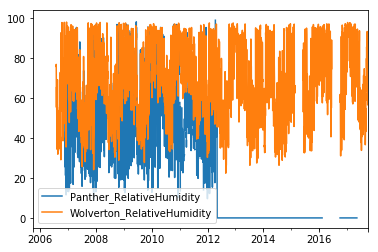

In [37]:
indexUnique = pd.date_range(str(prep.index[0]), str(prep.index[-1]))  
ready_columns = pd.unique(prep.columns)  
siteList = ready_columns
nan_values = np.nan*np.ones([len(indexUnique),len(ready_columns)])
df = pd.DataFrame(nan_values, index=indexUnique, columns = ready_columns) 

plt.figure(figsize=(10,4))
for i in np.arange(len(ready_columns)):  
    print(siteList[i])            
    site = siteList[i]     
    tab = prep[site]

    for j in np.arange(len(prep)):  
        df.loc[tab.index[j]][ready_columns[i]] = tab[j] # 
RelativeHumidity = copy.deepcopy(df)
RelativeHumidity.plot()
RelativeHumidity.head(2)

### 6. WindDirection

In [38]:
df_lst=[]
for i in range(len(linklist_Panther)):
    link = linklist_Panther[i]
    print(2005 + i)
    data = pd.read_csv(link,index_col = "TIMESTAMP",parse_dates = True, infer_datetime_format = True, header = 0)  
    var = pd.DataFrame(pd.to_numeric(data['WindDir_D1_WVT'],errors = 'coerce'))
    var.columns = ['Panther_WindDirection']
    var = threC(var,'WindDirection')
    var.index = pd.to_datetime(var.index)
    display(var.head(2))
    df_lst.append(var)
prep1=aggre_and_comb_daily(df_lst, axis=0, func = "mean") 

2005


Panther_WindDirection
TIMESTAMP                                 
2005-10-01 00:00:00                    NaN
2005-10-01 01:00:00                    NaN

2006


Panther_WindDirection
TIMESTAMP                                 
2006-10-01 00:00:00                    NaN
2006-10-01 01:00:00                    NaN

2007


Panther_WindDirection
TIMESTAMP                                 
2007-10-01 00:00:00                  276.6
2007-10-01 01:00:00                  333.9

2008


Panther_WindDirection
TIMESTAMP                                 
2008-10-01 00:00:00                  182.6
2008-10-01 01:00:00                  205.1

2009


Panther_WindDirection
TIMESTAMP                                 
2009-10-01 00:00:00                  198.9
2009-10-01 01:00:00                  200.9

2010


Panther_WindDirection
TIMESTAMP                                 
2010-10-01 00:00:00                  198.0
2010-10-01 01:00:00                  197.8

2011


Panther_WindDirection
TIMESTAMP                                 
2011-10-01 00:00:00                  296.1
2011-10-01 01:00:00                  238.1

2012


Panther_WindDirection
TIMESTAMP                                 
2012-10-01 00:00:00                  199.9
2012-10-01 01:00:00                  197.8

2013


Panther_WindDirection
TIMESTAMP                                 
2013-10-01 00:00:00                  208.5
2013-10-01 01:00:00                  194.7

2014


Panther_WindDirection
TIMESTAMP                                 
2014-10-01 00:00:00                  198.6
2014-10-01 01:00:00                  198.5

2015


Panther_WindDirection
TIMESTAMP                                 
2015-10-01 00:00:00                  191.2
2015-10-01 01:00:00                  206.0

2016


Panther_WindDirection
TIMESTAMP                                 
2016-10-01 00:00:00                  137.1
2016-10-01 01:00:00                  134.7

['Panther_WindDirection', datetime.date(2008, 1, 13)]
nan ratio is 0.08333333333333333 , groupby value is 149.91727272727272
['Panther_WindDirection', datetime.date(2009, 5, 25)]
nan ratio is 0.041666666666666664 , groupby value is 195.14047826086954
['Panther_WindDirection', datetime.date(2016, 10, 13)]
nan ratio is 0.08333333333333333 , groupby value is 195.59909090909088
The final table is:


Panther_WindDirection
DateTime                        
2005-10-01                   NaN
2005-10-02                   NaN

Panther_WindDirection
DateTime                        
2017-09-29                   NaN
2017-09-30                   NaN

In [39]:
df_lst=[]
for i in range(len(linklist_Wolverton)):
    link = linklist_Wolverton[i]
    print(2005 + i)
    data = pd.read_csv(link,index_col = "TIMESTAMP",parse_dates = True, infer_datetime_format = True, header = 0)  
    var = pd.DataFrame(pd.to_numeric(data['WindDir_D1_WVT'],errors = 'coerce'))
    var.columns = ['Wolverton_WindDirection']
    var = threC(var,'WindDirection')
    var.index = pd.to_datetime(var.index)
    display(var.head(2))
    df_lst.append(var)
prep2=aggre_and_comb_daily(df_lst, axis=0, func = "mean") 

2005


Wolverton_WindDirection
TIMESTAMP                                   
2005-10-01 00:00:00                      NaN
2005-10-01 01:00:00                      NaN

2006


Wolverton_WindDirection
TIMESTAMP                                   
2006-10-01 00:00:00                    77.86
2006-10-01 01:00:00                    77.82

2007


Wolverton_WindDirection
TIMESTAMP                                   
2007-10-01 00:00:00                    55.20
2007-10-01 01:00:00                    55.63

2008


Wolverton_WindDirection
TIMESTAMP                                   
2008-10-01 00:00:00                    66.66
2008-10-01 01:00:00                     0.00

2009


Wolverton_WindDirection
TIMESTAMP                                   
2009-10-01 00:00:00                    43.35
2009-10-01 01:00:00                    43.36

2010


Wolverton_WindDirection
TIMESTAMP                                   
2010-10-01 00:00:00                    25.33
2010-10-01 01:00:00                     0.00

2011


Wolverton_WindDirection
TIMESTAMP                                   
2011-10-01 00:00:00                    63.44
2011-10-01 01:00:00                    89.20

2012


Wolverton_WindDirection
TIMESTAMP                                   
2012-10-01 00:00:00                     0.00
2012-10-01 01:00:00                    41.25

2013


Wolverton_WindDirection
TIMESTAMP                                   
2013-10-01 00:00:00                      0.0
2013-10-01 01:00:00                     40.6

2014


Wolverton_WindDirection
TIMESTAMP                                   
2014-10-01 00:00:00                    51.98
2014-10-01 01:00:00                    52.04

2015


Wolverton_WindDirection
TIMESTAMP                                   
2015-10-01 00:00:00                      0.0
2015-10-01 01:00:00                      0.0

2016


Wolverton_WindDirection
TIMESTAMP                                   
2016-10-01 00:00:00                     0.00
2016-10-01 01:00:00                    75.98

['Wolverton_WindDirection', datetime.date(2007, 10, 13)]
nan ratio is 0.08333333333333333 , groupby value is 82.57999999999998
['Wolverton_WindDirection', datetime.date(2008, 1, 13)]
nan ratio is 0.041666666666666664 , groupby value is 71.55217391304348
['Wolverton_WindDirection', datetime.date(2009, 5, 24)]
nan ratio is 0.041666666666666664 , groupby value is 144.29130434782613
The final table is:


Wolverton_WindDirection
DateTime                          
2005-10-01                     NaN
2005-10-02                     NaN

Wolverton_WindDirection
DateTime                          
2017-09-29                 109.215
2017-09-30                 126.769

In [40]:
prep = aggre_and_comb_daily([prep1,prep2], axis=1, func = "mean") 

The final table is:


Panther_WindDirection Wolverton_WindDirection
2005-10-01                   NaN                     NaN
2005-10-02                   NaN                     NaN

Panther_WindDirection Wolverton_WindDirection
2017-09-29                   NaN                 109.215
2017-09-30                   NaN                 126.769

Panther_WindDirection
Wolverton_WindDirection


Panther_WindDirection  Wolverton_WindDirection
2005-10-01                    NaN                      NaN
2005-10-02                    NaN                      NaN

<Figure size 720x288 with 0 Axes>

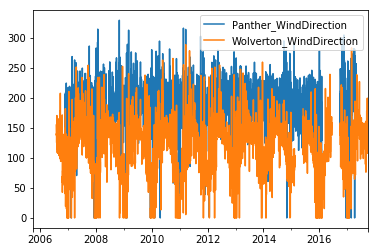

In [41]:
indexUnique = pd.date_range(str(prep.index[0]), str(prep.index[-1]))  
ready_columns = pd.unique(prep.columns)  
siteList = ready_columns
nan_values = np.nan*np.ones([len(indexUnique),len(ready_columns)])
df = pd.DataFrame(nan_values, index=indexUnique, columns = ready_columns) 

plt.figure(figsize=(10,4))
for i in np.arange(len(ready_columns)):  
    print(siteList[i])            
    site = siteList[i]     
    tab = prep[site]

    for j in np.arange(len(prep)):  
        df.loc[tab.index[j]][ready_columns[i]] = tab[j] # 
WindDirection = copy.deepcopy(df)
WindDirection.plot()
WindDirection.head(2)

### 7. WindSpeed

In [42]:
df_lst=[]
for i in range(len(linklist_Panther)):
    link = linklist_Panther[i]
    print(2005 + i)
    data = pd.read_csv(link,index_col = "TIMESTAMP",parse_dates = True, infer_datetime_format = True, header = 0)  
    var = pd.DataFrame(pd.to_numeric(data['WS_ms_Avg'],errors = 'coerce'))
    var.columns = ['Panther_WindSpeed']
    var = threC(var,'WindSpeed')
    var.index = pd.to_datetime(var.index)
    display(var.head(2))
    df_lst.append(var)
prep1=aggre_and_comb_daily(df_lst, axis=0, func = "mean") 

2005


Panther_WindSpeed
TIMESTAMP                             
2005-10-01 00:00:00                NaN
2005-10-01 01:00:00                NaN

2006


Panther_WindSpeed
TIMESTAMP                             
2006-10-01 00:00:00                NaN
2006-10-01 01:00:00                NaN

2007


Panther_WindSpeed
TIMESTAMP                             
2007-10-01 00:00:00              0.536
2007-10-01 01:00:00              0.688

2008


Panther_WindSpeed
TIMESTAMP                             
2008-10-01 00:00:00              0.211
2008-10-01 01:00:00              0.261

2009


Panther_WindSpeed
TIMESTAMP                             
2009-10-01 00:00:00              0.393
2009-10-01 01:00:00              0.542

2010


Panther_WindSpeed
TIMESTAMP                             
2010-10-01 00:00:00              0.379
2010-10-01 01:00:00              0.431

2011


Panther_WindSpeed
TIMESTAMP                             
2011-10-01 00:00:00              0.638
2011-10-01 01:00:00              0.613

2012


Panther_WindSpeed
TIMESTAMP                             
2012-10-01 00:00:00              0.672
2012-10-01 01:00:00              0.615

2013


Panther_WindSpeed
TIMESTAMP                             
2013-10-01 00:00:00              0.272
2013-10-01 01:00:00              0.580

2014


Panther_WindSpeed
TIMESTAMP                             
2014-10-01 00:00:00              0.556
2014-10-01 01:00:00              0.686

2015


Panther_WindSpeed
TIMESTAMP                             
2015-10-01 00:00:00              0.441
2015-10-01 01:00:00              0.244

2016


Panther_WindSpeed
TIMESTAMP                             
2016-10-01 00:00:00              0.396
2016-10-01 01:00:00              0.764

['Panther_WindSpeed', datetime.date(2008, 1, 13)]
nan ratio is 0.08333333333333333 , groupby value is 0.8751818181818181
['Panther_WindSpeed', datetime.date(2009, 5, 25)]
nan ratio is 0.041666666666666664 , groupby value is 0.5212173913043479
['Panther_WindSpeed', datetime.date(2016, 10, 13)]
nan ratio is 0.08333333333333333 , groupby value is 0.5190909090909092
The final table is:


Panther_WindSpeed
DateTime                    
2005-10-01               NaN
2005-10-02               NaN

Panther_WindSpeed
DateTime                    
2017-09-29               NaN
2017-09-30               NaN

In [43]:
df_lst=[]
for i in range(len(linklist_Wolverton)):
    link = linklist_Wolverton[i]
    print(2005 + i)
    data = pd.read_csv(link,index_col = "TIMESTAMP",parse_dates = True, infer_datetime_format = True, header = 0)  
    var = pd.DataFrame(pd.to_numeric(data['WS_ms_Avg'],errors = 'coerce'))
    var.columns = ['Wolverton_WindSpeed']
    var = threC(var,'WindSpeed')
    var.index = pd.to_datetime(var.index)
    display(var.head(2))
    df_lst.append(var)
prep2=aggre_and_comb_daily(df_lst, axis=0, func = "mean") 

2005


Wolverton_WindSpeed
TIMESTAMP                               
2005-10-01 00:00:00                  NaN
2005-10-01 01:00:00                  NaN

2006


Wolverton_WindSpeed
TIMESTAMP                               
2006-10-01 00:00:00                0.013
2006-10-01 01:00:00                0.005

2007


Wolverton_WindSpeed
TIMESTAMP                               
2007-10-01 00:00:00                0.054
2007-10-01 01:00:00                0.064

2008


Wolverton_WindSpeed
TIMESTAMP                               
2008-10-01 00:00:00                0.001
2008-10-01 01:00:00                0.000

2009


Wolverton_WindSpeed
TIMESTAMP                               
2009-10-01 00:00:00                 0.01
2009-10-01 01:00:00                 0.00

2010


Wolverton_WindSpeed
TIMESTAMP                               
2010-10-01 00:00:00                0.002
2010-10-01 01:00:00                0.000

2011


Wolverton_WindSpeed
TIMESTAMP                               
2011-10-01 00:00:00                0.082
2011-10-01 01:00:00                0.374

2012


Wolverton_WindSpeed
TIMESTAMP                               
2012-10-01 00:00:00                0.000
2012-10-01 01:00:00                0.003

2013


Wolverton_WindSpeed
TIMESTAMP                               
2013-10-01 00:00:00                0.000
2013-10-01 01:00:00                0.006

2014


Wolverton_WindSpeed
TIMESTAMP                               
2014-10-01 00:00:00                0.013
2014-10-01 01:00:00                0.004

2015


Wolverton_WindSpeed
TIMESTAMP                               
2015-10-01 00:00:00                  0.0
2015-10-01 01:00:00                  0.0

2016


Wolverton_WindSpeed
TIMESTAMP                               
2016-10-01 00:00:00                0.000
2016-10-01 01:00:00                0.001

['Wolverton_WindSpeed', datetime.date(2007, 10, 13)]
nan ratio is 0.08333333333333333 , groupby value is 0.050136363636363625
['Wolverton_WindSpeed', datetime.date(2008, 1, 13)]
nan ratio is 0.041666666666666664 , groupby value is 0.13691304347826086
['Wolverton_WindSpeed', datetime.date(2009, 5, 24)]
nan ratio is 0.041666666666666664 , groupby value is 0.24230434782608698
The final table is:


Wolverton_WindSpeed
DateTime                      
2005-10-01                 NaN
2005-10-02                 NaN

Wolverton_WindSpeed
DateTime                      
2017-09-29            0.172042
2017-09-30            0.152083

In [44]:
prep = aggre_and_comb_daily([prep1,prep2], axis=1, func = "mean") 

The final table is:


Panther_WindSpeed Wolverton_WindSpeed
2005-10-01               NaN                 NaN
2005-10-02               NaN                 NaN

Panther_WindSpeed Wolverton_WindSpeed
2017-09-29               NaN            0.172042
2017-09-30               NaN            0.152083

Panther_WindSpeed
Wolverton_WindSpeed


Panther_WindSpeed  Wolverton_WindSpeed
2005-10-01                NaN                  NaN
2005-10-02                NaN                  NaN

<Figure size 720x288 with 0 Axes>

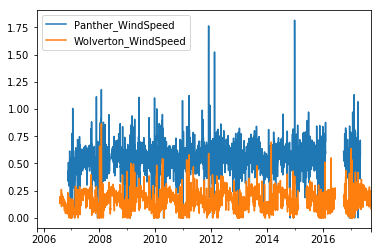

In [45]:
indexUnique = pd.date_range(str(prep.index[0]), str(prep.index[-1]))  
ready_columns = pd.unique(prep.columns)  
siteList = ready_columns
nan_values = np.nan*np.ones([len(indexUnique),len(ready_columns)])
df = pd.DataFrame(nan_values, index=indexUnique, columns = ready_columns) 

plt.figure(figsize=(10,4))
for i in np.arange(len(ready_columns)):  
    print(siteList[i])            
    site = siteList[i]     
    tab = prep[site]

    for j in np.arange(len(prep)):  
        df.loc[tab.index[j]][ready_columns[i]] = tab[j] # 
WindSpeed = copy.deepcopy(df)
WindSpeed.plot()
WindSpeed.head(2)

### 8. SWE

### 9. SnowDepth

In [58]:
linklist_SD = ['https://eng.ucmerced.edu/snsjho/files/MHWG/Field/SEKI/Wolverton/Gap_filled_snow/gap_filled_wolv_wy2007_snow.csv',
              'https://eng.ucmerced.edu/snsjho/files/MHWG/Field/SEKI/Wolverton/Gap_filled_snow/gap_filled_wolv_wy2008_snow.csv',
              'https://eng.ucmerced.edu/snsjho/files/MHWG/Field/SEKI/Wolverton/Gap_filled_snow/gap_filled_wolv_wy2009_snow.csv',
              'https://eng.ucmerced.edu/snsjho/files/MHWG/Field/SEKI/Wolverton/Gap_filled_snow/gap_filled_wolv_wy2010_snow.csv']
df_lst=[]
for i in range(len(linklist_SD)):
    link = linklist_SD[i]
    print(2007 + i)
    if i == 0:
        data = pd.read_csv(link,index_col = "date_time " ,parse_dates = True, 
                           infer_datetime_format = True, header = 0) 
        var = copy.deepcopy(data[['2_2', '2_4', '4_3', '4_4']])
        var.columns = ['Wolverton_SnowDepth_' + i.split('_')[0][0] + i.split('_')[1][0] for i in var.columns]
        
    elif i == 1:
        data = pd.read_csv(link,index_col = "date_time", parse_dates = True, 
                           infer_datetime_format = True, header = 0) 
        var = copy.deepcopy(data[[ '1_1 ', '1_2 ',  '1_3 ', '1_4 ', '1_5 ',  '1_6 ',  
                                  '2_1 ','2_2 ',  '2_3 ', '2_4 ', '2_5 ',  '2_6 ', 
                                  '3_1 ',  '3_2 ','3_3 ',  '3_4 ',  '3_5 ',
                                  '4_1 ',  '4_2 ',  '4_3 ','4_4 ',  '4_5 ']])
        var.columns = ['Wolverton_SnowDepth_' + i.split('_')[0][0] + i.split('_')[1][0] for i in var.columns]     
        
    elif i == 2:
        data = pd.read_csv(link,index_col = "date_time", parse_dates = True, 
                           infer_datetime_format = True, header = 0) 
        var = copy.deepcopy(data[[ '1_1 ', '1_2 ',  '1_3 ', '1_4 ', '1_5 ',  '1_6 ',  
                                  '2_1 ','2_2 ',  '2_3 ', '2_4 ', '2_5 ',  '2_6 ', 
                                    '3_2 ','3_3 ',  '3_4 ',  '3_5 ',
                                  '4_1 ',  '4_2 ',  '4_3 ','4_4 ']])
        var.columns = ['Wolverton_SnowDepth_' + i.split('_')[0][0] + i.split('_')[1][0] for i in var.columns]
    
    else:
        data = pd.read_csv(link,index_col = "date_time", parse_dates = True, 
                           infer_datetime_format = True, header = 0) 
        var = copy.deepcopy(data[[  '1_2 ',  '1_3 ', '1_4 ', '1_5 ',  '1_6 ',  
                                  '2_1 ','2_2 ',  '2_3 ', '2_4 ', '2_5 ',  '2_6 ', 
                                  '3_1 ',  '3_2 ','3_3 ',  '3_4 ',  '3_5 ',
                                  '4_1 ',  '4_2 ',  '4_3 ','4_4 ',  '4_5 ']])
        var.columns = ['Wolverton_SnowDepth_' + i.split('_')[0][0] + i.split('_')[1][0] for i in var.columns]          
    display(var.head(3))
    var = threC(var,'SnowDepth')
    var.index = pd.to_datetime(var.index)
    display(var.head(2))
    df_lst.append(var)
    
prep1=aggre_and_comb_daily(df_lst, axis=0, func = "mean") 

2007


Wolverton_SnowDepth_22  Wolverton_SnowDepth_24  \
date_time                                                             
2007-01-25 19:00:00                    19.5                    33.4   
2007-01-25 20:00:00                    19.5                    33.9   
2007-01-25 21:00:00                    19.7                    33.4   

                     Wolverton_SnowDepth_43  Wolverton_SnowDepth_44  
date_time                                                            
2007-01-25 19:00:00                  -999.0                  -999.0  
2007-01-25 20:00:00                  -999.0                  -999.0  
2007-01-25 21:00:00                  -999.0                  -999.0

Wolverton_SnowDepth_22  Wolverton_SnowDepth_24  \
date_time                                                             
2007-01-25 19:00:00                    19.5                    33.4   
2007-01-25 20:00:00                    19.5                    33.9   

                     Wolverton_SnowDepth_43  Wolverton_SnowDepth_44  
date_time                                                            
2007-01-25 19:00:00                     NaN                     NaN  
2007-01-25 20:00:00                     NaN                     NaN

2008


Wolverton_SnowDepth_11  Wolverton_SnowDepth_12  \
date_time                                                             
2007-10-01 00:00:00                     0.0                     0.0   
2007-10-01 01:00:00                     0.0                     0.0   
2007-10-01 02:00:00                     0.0                     0.0   

                     Wolverton_SnowDepth_13  Wolverton_SnowDepth_14  \
date_time                                                             
2007-10-01 00:00:00                     0.0                     0.0   
2007-10-01 01:00:00                     0.0                     0.0   
2007-10-01 02:00:00                     0.0                     0.0   

                     Wolverton_SnowDepth_15  Wolverton_SnowDepth_16  \
date_time                                                             
2007-10-01 00:00:00                     0.0                     0.0   
2007-10-01 01:00:00                     0.0                     0.0   
2007-10-01 02:00:00                     0.0                     0.0   

                     Wolverton_SnowDepth_21  Wolverton_SnowDepth_22  \
date_time                                                             
2007-10-01 00:00:00                     0.0                4.166926   
2007-10-01 01:00:00                     0.0                4.166926   
2007-10-01 02:00:00                     0.0                4.166926   

                     Wolverton_SnowDepth_23  Wolverton_SnowDepth_24  ...  \
date_time                                                            ...   
2007-10-01 00:00:00                     0.0                4.473433  ...   
2007-10-01 01:00:00                     0.0                4.473433  ...   
2007-10-01 02:00:00                     0.0                4.473433  ...   

                     Wolverton_SnowDepth_31  Wolverton_SnowDepth_32  \
date_time                                                             
2007-10-01 00:00:00                2.381436                     0.0   
2007-10-01 01:00:00                2.381436                     0.0   
2007-10-01 02:00:00                2.381436                     0.0   

                     Wolverton_SnowDepth_33  Wolverton_SnowDepth_34  \
date_time                                                             
2007-10-01 00:00:00                     0.0                     0.0   
2007-10-01 01:00:00                     0.0                     0.0   
2007-10-01 02:00:00                     0.0                     0.0   

                     Wolverton_SnowDepth_35  Wolverton_SnowDepth_41  \
date_time                                                             
2007-10-01 00:00:00               11.091386                     0.0   
2007-10-01 01:00:00               11.091386                     0.0   
2007-10-01 02:00:00               11.091386                     0.0   

                     Wolverton_SnowDepth_42  Wolverton_SnowDepth_43  \
date_time                                                             
2007-10-01 00:00:00                     0.0                     0.0   
2007-10-01 01:00:00                     0.0                     0.0   
2007-10-01 02:00:00                     0.0                     0.0   

                     Wolverton_SnowDepth_44  Wolverton_SnowDepth_45  
date_time                                                            
2007-10-01 00:00:00                     0.0                     0.1  
2007-10-01 01:00:00                     0.0                     0.1  
2007-10-01 02:00:00                     0.0                     0.1  

[3 rows x 22 columns]

Wolverton_SnowDepth_11  Wolverton_SnowDepth_12  \
date_time                                                             
2007-10-01 00:00:00                     0.0                     0.0   
2007-10-01 01:00:00                     0.0                     0.0   

                     Wolverton_SnowDepth_13  Wolverton_SnowDepth_14  \
date_time                                                             
2007-10-01 00:00:00                     0.0                     0.0   
2007-10-01 01:00:00                     0.0                     0.0   

                     Wolverton_SnowDepth_15  Wolverton_SnowDepth_16  \
date_time                                                             
2007-10-01 00:00:00                     0.0                     0.0   
2007-10-01 01:00:00                     0.0                     0.0   

                     Wolverton_SnowDepth_21  Wolverton_SnowDepth_22  \
date_time                                                             
2007-10-01 00:00:00                     0.0                4.166926   
2007-10-01 01:00:00                     0.0                4.166926   

                     Wolverton_SnowDepth_23  Wolverton_SnowDepth_24  ...  \
date_time                                                            ...   
2007-10-01 00:00:00                     0.0                4.473433  ...   
2007-10-01 01:00:00                     0.0                4.473433  ...   

                     Wolverton_SnowDepth_31  Wolverton_SnowDepth_32  \
date_time                                                             
2007-10-01 00:00:00                2.381436                     0.0   
2007-10-01 01:00:00                2.381436                     0.0   

                     Wolverton_SnowDepth_33  Wolverton_SnowDepth_34  \
date_time                                                             
2007-10-01 00:00:00                     0.0                     0.0   
2007-10-01 01:00:00                     0.0                     0.0   

                     Wolverton_SnowDepth_35  Wolverton_SnowDepth_41  \
date_time                                                             
2007-10-01 00:00:00               11.091386                     0.0   
2007-10-01 01:00:00               11.091386                     0.0   

                     Wolverton_SnowDepth_42  Wolverton_SnowDepth_43  \
date_time                                                             
2007-10-01 00:00:00                     0.0                     0.0   
2007-10-01 01:00:00                     0.0                     0.0   

                     Wolverton_SnowDepth_44  Wolverton_SnowDepth_45  
date_time                                                            
2007-10-01 00:00:00                     0.0                     0.1  
2007-10-01 01:00:00                     0.0                     0.1  

[2 rows x 22 columns]

2009


Wolverton_SnowDepth_11  Wolverton_SnowDepth_12  \
date_time                                                             
2008-10-01 00:00:00                     0.0                     0.0   
2008-10-01 01:00:00                     0.0                     0.0   
2008-10-01 02:00:00                     0.0                     0.0   

                     Wolverton_SnowDepth_13  Wolverton_SnowDepth_14  \
date_time                                                             
2008-10-01 00:00:00                     0.0                     0.0   
2008-10-01 01:00:00                     0.0                     0.0   
2008-10-01 02:00:00                     0.0                     0.0   

                     Wolverton_SnowDepth_15  Wolverton_SnowDepth_16  \
date_time                                                             
2008-10-01 00:00:00                     0.0                     0.0   
2008-10-01 01:00:00                     0.0                     0.0   
2008-10-01 02:00:00                     0.0                     0.0   

                     Wolverton_SnowDepth_21  Wolverton_SnowDepth_22  \
date_time                                                             
2008-10-01 00:00:00                     0.0                     0.0   
2008-10-01 01:00:00                     0.0                     0.0   
2008-10-01 02:00:00                     0.0                     0.0   

                     Wolverton_SnowDepth_23  Wolverton_SnowDepth_24  \
date_time                                                             
2008-10-01 00:00:00                     0.0                     0.0   
2008-10-01 01:00:00                     0.0                     0.0   
2008-10-01 02:00:00                     0.0                     0.0   

                     Wolverton_SnowDepth_25  Wolverton_SnowDepth_26  \
date_time                                                             
2008-10-01 00:00:00                     0.0                     0.0   
2008-10-01 01:00:00                     0.0                     0.0   
2008-10-01 02:00:00                     0.0                     0.0   

                     Wolverton_SnowDepth_32  Wolverton_SnowDepth_33  \
date_time                                                             
2008-10-01 00:00:00                     0.0                     0.0   
2008-10-01 01:00:00                     0.0                     0.0   
2008-10-01 02:00:00                     0.0                     0.0   

                     Wolverton_SnowDepth_34  Wolverton_SnowDepth_35  \
date_time                                                             
2008-10-01 00:00:00                     0.0                     0.0   
2008-10-01 01:00:00                     0.0                     0.0   
2008-10-01 02:00:00                     0.0                     0.0   

                     Wolverton_SnowDepth_41  Wolverton_SnowDepth_42  \
date_time                                                             
2008-10-01 00:00:00                     0.0                     0.0   
2008-10-01 01:00:00                     0.0                     0.0   
2008-10-01 02:00:00                     0.0                     0.0   

                     Wolverton_SnowDepth_43  Wolverton_SnowDepth_44  
date_time                                                            
2008-10-01 00:00:00                     0.0                     0.0  
2008-10-01 01:00:00                     0.0                     0.0  
2008-10-01 02:00:00                     0.0                     0.0

Wolverton_SnowDepth_11  Wolverton_SnowDepth_12  \
date_time                                                             
2008-10-01 00:00:00                     0.0                     0.0   
2008-10-01 01:00:00                     0.0                     0.0   

                     Wolverton_SnowDepth_13  Wolverton_SnowDepth_14  \
date_time                                                             
2008-10-01 00:00:00                     0.0                     0.0   
2008-10-01 01:00:00                     0.0                     0.0   

                     Wolverton_SnowDepth_15  Wolverton_SnowDepth_16  \
date_time                                                             
2008-10-01 00:00:00                     0.0                     0.0   
2008-10-01 01:00:00                     0.0                     0.0   

                     Wolverton_SnowDepth_21  Wolverton_SnowDepth_22  \
date_time                                                             
2008-10-01 00:00:00                     0.0                     0.0   
2008-10-01 01:00:00                     0.0                     0.0   

                     Wolverton_SnowDepth_23  Wolverton_SnowDepth_24  \
date_time                                                             
2008-10-01 00:00:00                     0.0                     0.0   
2008-10-01 01:00:00                     0.0                     0.0   

                     Wolverton_SnowDepth_25  Wolverton_SnowDepth_26  \
date_time                                                             
2008-10-01 00:00:00                     0.0                     0.0   
2008-10-01 01:00:00                     0.0                     0.0   

                     Wolverton_SnowDepth_32  Wolverton_SnowDepth_33  \
date_time                                                             
2008-10-01 00:00:00                     0.0                     0.0   
2008-10-01 01:00:00                     0.0                     0.0   

                     Wolverton_SnowDepth_34  Wolverton_SnowDepth_35  \
date_time                                                             
2008-10-01 00:00:00                     0.0                     0.0   
2008-10-01 01:00:00                     0.0                     0.0   

                     Wolverton_SnowDepth_41  Wolverton_SnowDepth_42  \
date_time                                                             
2008-10-01 00:00:00                     0.0                     0.0   
2008-10-01 01:00:00                     0.0                     0.0   

                     Wolverton_SnowDepth_43  Wolverton_SnowDepth_44  
date_time                                                            
2008-10-01 00:00:00                     0.0                     0.0  
2008-10-01 01:00:00                     0.0                     0.0

2010


Wolverton_SnowDepth_12  Wolverton_SnowDepth_13  \
date_time                                                             
2009-10-01 00:00:00                     0.0                     0.0   
2009-10-01 01:00:00                     0.0                     0.0   
2009-10-01 02:00:00                     0.0                     0.0   

                     Wolverton_SnowDepth_14  Wolverton_SnowDepth_15  \
date_time                                                             
2009-10-01 00:00:00                     0.0                     0.0   
2009-10-01 01:00:00                     0.0                     0.0   
2009-10-01 02:00:00                     0.0                     0.0   

                     Wolverton_SnowDepth_16  Wolverton_SnowDepth_21  \
date_time                                                             
2009-10-01 00:00:00                     0.0                     0.0   
2009-10-01 01:00:00                     0.0                     0.0   
2009-10-01 02:00:00                     0.0                     0.0   

                     Wolverton_SnowDepth_22  Wolverton_SnowDepth_23  \
date_time                                                             
2009-10-01 00:00:00                3.923497                     0.0   
2009-10-01 01:00:00                3.923497                     0.0   
2009-10-01 02:00:00                3.923497                     0.0   

                     Wolverton_SnowDepth_24  Wolverton_SnowDepth_25  ...  \
date_time                                                            ...   
2009-10-01 00:00:00                     0.0                     0.0  ...   
2009-10-01 01:00:00                     0.0                     0.0  ...   
2009-10-01 02:00:00                     0.0                     0.0  ...   

                     Wolverton_SnowDepth_31  Wolverton_SnowDepth_32  \
date_time                                                             
2009-10-01 00:00:00                     0.0                     0.0   
2009-10-01 01:00:00                     0.0                     0.0   
2009-10-01 02:00:00                     0.0                     0.0   

                     Wolverton_SnowDepth_33  Wolverton_SnowDepth_34  \
date_time                                                             
2009-10-01 00:00:00                     0.0                     0.0   
2009-10-01 01:00:00                     0.0                     0.0   
2009-10-01 02:00:00                     0.0                     0.0   

                     Wolverton_SnowDepth_35  Wolverton_SnowDepth_41  \
date_time                                                             
2009-10-01 00:00:00                     0.0                     0.0   
2009-10-01 01:00:00                     0.0                     0.0   
2009-10-01 02:00:00                     0.0                     0.0   

                     Wolverton_SnowDepth_42  Wolverton_SnowDepth_43  \
date_time                                                             
2009-10-01 00:00:00                     0.0                     0.0   
2009-10-01 01:00:00                     0.0                     0.0   
2009-10-01 02:00:00                     0.0                     0.0   

                     Wolverton_SnowDepth_44  Wolverton_SnowDepth_45  
date_time                                                            
2009-10-01 00:00:00                     0.0                     0.0  
2009-10-01 01:00:00                     0.0                     0.0  
2009-10-01 02:00:00                     0.0                     0.0  

[3 rows x 21 columns]

Wolverton_SnowDepth_12  Wolverton_SnowDepth_13  \
date_time                                                             
2009-10-01 00:00:00                     0.0                     0.0   
2009-10-01 01:00:00                     0.0                     0.0   

                     Wolverton_SnowDepth_14  Wolverton_SnowDepth_15  \
date_time                                                             
2009-10-01 00:00:00                     0.0                     0.0   
2009-10-01 01:00:00                     0.0                     0.0   

                     Wolverton_SnowDepth_16  Wolverton_SnowDepth_21  \
date_time                                                             
2009-10-01 00:00:00                     0.0                     0.0   
2009-10-01 01:00:00                     0.0                     0.0   

                     Wolverton_SnowDepth_22  Wolverton_SnowDepth_23  \
date_time                                                             
2009-10-01 00:00:00                3.923497                     0.0   
2009-10-01 01:00:00                3.923497                     0.0   

                     Wolverton_SnowDepth_24  Wolverton_SnowDepth_25  ...  \
date_time                                                            ...   
2009-10-01 00:00:00                     0.0                     0.0  ...   
2009-10-01 01:00:00                     0.0                     0.0  ...   

                     Wolverton_SnowDepth_31  Wolverton_SnowDepth_32  \
date_time                                                             
2009-10-01 00:00:00                     0.0                     0.0   
2009-10-01 01:00:00                     0.0                     0.0   

                     Wolverton_SnowDepth_33  Wolverton_SnowDepth_34  \
date_time                                                             
2009-10-01 00:00:00                     0.0                     0.0   
2009-10-01 01:00:00                     0.0                     0.0   

                     Wolverton_SnowDepth_35  Wolverton_SnowDepth_41  \
date_time                                                             
2009-10-01 00:00:00                     0.0                     0.0   
2009-10-01 01:00:00                     0.0                     0.0   

                     Wolverton_SnowDepth_42  Wolverton_SnowDepth_43  \
date_time                                                             
2009-10-01 00:00:00                     0.0                     0.0   
2009-10-01 01:00:00                     0.0                     0.0   

                     Wolverton_SnowDepth_44  Wolverton_SnowDepth_45  
date_time                                                            
2009-10-01 00:00:00                     0.0                     0.0  
2009-10-01 01:00:00                     0.0                     0.0  

[2 rows x 21 columns]

['Wolverton_SnowDepth_44', datetime.date(2007, 5, 4)]
nan ratio is 0.08333333333333333 , groupby value is 4.7334709765000005
['Wolverton_SnowDepth_44', datetime.date(2007, 5, 8)]
nan ratio is 0.041666666666666664 , groupby value is 4.731174185173912
['Wolverton_SnowDepth_44', datetime.date(2007, 5, 10)]
nan ratio is 0.08333333333333333 , groupby value is 3.3930374238636363
['Wolverton_SnowDepth_24', datetime.date(2009, 12, 7)]
nan ratio is 0.041666666666666664 , groupby value is 14.199450772086958
The final table is:


Wolverton_SnowDepth_22 Wolverton_SnowDepth_24  \
DateTime                                                   
2007-01-25                  19.62                   33.5   
2007-01-26                19.4917                33.8354   

           Wolverton_SnowDepth_43 Wolverton_SnowDepth_44  \
DateTime                                                   
2007-01-25                    NaN                    NaN   
2007-01-26                    NaN                    NaN   

           Wolverton_SnowDepth_11 Wolverton_SnowDepth_12  \
DateTime                                                   
2007-01-25                    NaN                    NaN   
2007-01-26                    NaN                    NaN   

           Wolverton_SnowDepth_13 Wolverton_SnowDepth_14  \
DateTime                                                   
2007-01-25                    NaN                    NaN   
2007-01-26                    NaN                    NaN   

           Wolverton_SnowDepth_15 Wolverton_SnowDepth_16  ...  \
DateTime                                                  ...   
2007-01-25                    NaN                    NaN  ...   
2007-01-26                    NaN                    NaN  ...   

           Wolverton_SnowDepth_25 Wolverton_SnowDepth_26  \
DateTime                                                   
2007-01-25                    NaN                    NaN   
2007-01-26                    NaN                    NaN   

           Wolverton_SnowDepth_31 Wolverton_SnowDepth_32  \
DateTime                                                   
2007-01-25                    NaN                    NaN   
2007-01-26                    NaN                    NaN   

           Wolverton_SnowDepth_33 Wolverton_SnowDepth_34  \
DateTime                                                   
2007-01-25                    NaN                    NaN   
2007-01-26                    NaN                    NaN   

           Wolverton_SnowDepth_35 Wolverton_SnowDepth_41  \
DateTime                                                   
2007-01-25                    NaN                    NaN   
2007-01-26                    NaN                    NaN   

           Wolverton_SnowDepth_42 Wolverton_SnowDepth_45  
DateTime                                                  
2007-01-25                    NaN                    NaN  
2007-01-26                    NaN                    NaN  

[2 rows x 22 columns]

Wolverton_SnowDepth_22 Wolverton_SnowDepth_24  \
DateTime                                                   
2010-09-29                 3.9235                      0   
2010-09-30                 3.9235                      0   

           Wolverton_SnowDepth_43 Wolverton_SnowDepth_44  \
DateTime                                                   
2010-09-29                      0                      0   
2010-09-30                      0                      0   

           Wolverton_SnowDepth_11 Wolverton_SnowDepth_12  \
DateTime                                                   
2010-09-29                    NaN                      0   
2010-09-30                    NaN                      0   

           Wolverton_SnowDepth_13 Wolverton_SnowDepth_14  \
DateTime                                                   
2010-09-29                      0                      0   
2010-09-30                      0                      0   

           Wolverton_SnowDepth_15 Wolverton_SnowDepth_16  ...  \
DateTime                                                  ...   
2010-09-29                      0                      0  ...   
2010-09-30                      0                      0  ...   

           Wolverton_SnowDepth_25 Wolverton_SnowDepth_26  \
DateTime                                                   
2010-09-29                      0                      0   
2010-09-30                      0                      0   

           Wolverton_SnowDepth_31 Wolverton_SnowDepth_32  \
DateTime                                                   
2010-09-29                      0                      0   
2010-09-30                      0                      0   

           Wolverton_SnowDepth_33 Wolverton_SnowDepth_34  \
DateTime                                                   
2010-09-29                      0                      0   
2010-09-30                      0                      0   

           Wolverton_SnowDepth_35 Wolverton_SnowDepth_41  \
DateTime                                                   
2010-09-29                      0                      0   
2010-09-30                      0                      0   

           Wolverton_SnowDepth_42 Wolverton_SnowDepth_45  
DateTime                                                  
2010-09-29                      0                      0  
2010-09-30                      0                      0  

[2 rows x 22 columns]

In [59]:
linklist_SD_2011 = ['https://eng.ucmerced.edu/snsjho/files/MHWG/Field/SEKI/Wolverton/Gap_filled_snow/2010_2011/daily_snow_depth_WaterYear_2010_2011_Site1.csv',
                   'https://eng.ucmerced.edu/snsjho/files/MHWG/Field/SEKI/Wolverton/Gap_filled_snow/2010_2011/daily_snow_depth_WaterYear_2010_2011_Site2.csv',
                   'https://eng.ucmerced.edu/snsjho/files/MHWG/Field/SEKI/Wolverton/Gap_filled_snow/2010_2011/daily_snow_depth_WaterYear_2010_2011_Site3.csv',
                   'https://eng.ucmerced.edu/snsjho/files/MHWG/Field/SEKI/Wolverton/Gap_filled_snow/2010_2011/daily_snow_depth_WaterYear_2010_2011_Site4.csv']
df_lst=[]
for i in range(len(linklist_SD_2011)):
    link = linklist_SD_2011[i]
    print('site' ,i + 1)
    data = pd.read_csv(link,index_col = "date_time" ,parse_dates = True, infer_datetime_format = True, header = 0) 
    var = copy.deepcopy(data[['1', '2', '3', '4','5','6']])
    var.columns = ['Wolverton_SnowDepth_' + str(i+1) + k for k in var.columns]
    var = threC(var,'SnowDepth')
    var.index = pd.to_datetime(var.index)
    display(var.head(2))
    df_lst.append(var)
    
prep2=aggre_and_comb_daily(df_lst, axis=0, func = "mean") 

site 1


Wolverton_SnowDepth_11  Wolverton_SnowDepth_12  \
date_time                                                    
2010-10-01                     0.0                     0.0   
2010-10-02                     0.0                     0.0   

            Wolverton_SnowDepth_13  Wolverton_SnowDepth_14  \
date_time                                                    
2010-10-01                     0.0                     0.0   
2010-10-02                     0.0                     0.0   

            Wolverton_SnowDepth_15  Wolverton_SnowDepth_16  
date_time                                                   
2010-10-01                     0.0                     0.0  
2010-10-02                     0.0                     0.0

site 2


Wolverton_SnowDepth_21  Wolverton_SnowDepth_22  \
date_time                                                    
2010-10-01                     0.0                     0.0   
2010-10-02                     0.0                     0.0   

            Wolverton_SnowDepth_23  Wolverton_SnowDepth_24  \
date_time                                                    
2010-10-01                     0.0                     0.0   
2010-10-02                     0.0                     0.0   

            Wolverton_SnowDepth_25  Wolverton_SnowDepth_26  
date_time                                                   
2010-10-01                     0.0                     0.0  
2010-10-02                     0.0                     0.0

site 3


Wolverton_SnowDepth_31  Wolverton_SnowDepth_32  \
date_time                                                    
2010-10-01                     0.0                     0.0   
2010-10-02                     0.0                     0.0   

            Wolverton_SnowDepth_33  Wolverton_SnowDepth_34  \
date_time                                                    
2010-10-01                     0.0                     0.0   
2010-10-02                     0.0                     0.0   

            Wolverton_SnowDepth_35  Wolverton_SnowDepth_36  
date_time                                                   
2010-10-01                     0.0                     0.0  
2010-10-02                     0.0                     0.0

site 4


Wolverton_SnowDepth_41  Wolverton_SnowDepth_42  \
date_time                                                    
2010-10-01                     0.0                     0.0   
2010-10-02                     0.0                     0.0   

            Wolverton_SnowDepth_43  Wolverton_SnowDepth_44  \
date_time                                                    
2010-10-01                     0.0                     0.0   
2010-10-02                     0.0                     0.0   

            Wolverton_SnowDepth_45  Wolverton_SnowDepth_46  
date_time                                                   
2010-10-01                     0.0                     0.0  
2010-10-02                     0.0                     0.0

The final table is:


Wolverton_SnowDepth_11 Wolverton_SnowDepth_12  \
DateTime                                                   
2010-10-01                      0                      0   
2010-10-02                      0                      0   

           Wolverton_SnowDepth_13 Wolverton_SnowDepth_14  \
DateTime                                                   
2010-10-01                      0                      0   
2010-10-02                      0                      0   

           Wolverton_SnowDepth_15 Wolverton_SnowDepth_16  \
DateTime                                                   
2010-10-01                      0                      0   
2010-10-02                      0                      0   

           Wolverton_SnowDepth_21 Wolverton_SnowDepth_22  \
DateTime                                                   
2010-10-01                    NaN                    NaN   
2010-10-02                    NaN                    NaN   

           Wolverton_SnowDepth_23 Wolverton_SnowDepth_24  ...  \
DateTime                                                  ...   
2010-10-01                    NaN                    NaN  ...   
2010-10-02                    NaN                    NaN  ...   

           Wolverton_SnowDepth_33 Wolverton_SnowDepth_34  \
DateTime                                                   
2010-10-01                    NaN                    NaN   
2010-10-02                    NaN                    NaN   

           Wolverton_SnowDepth_35 Wolverton_SnowDepth_36  \
DateTime                                                   
2010-10-01                    NaN                    NaN   
2010-10-02                    NaN                    NaN   

           Wolverton_SnowDepth_41 Wolverton_SnowDepth_42  \
DateTime                                                   
2010-10-01                    NaN                    NaN   
2010-10-02                    NaN                    NaN   

           Wolverton_SnowDepth_43 Wolverton_SnowDepth_44  \
DateTime                                                   
2010-10-01                    NaN                    NaN   
2010-10-02                    NaN                    NaN   

           Wolverton_SnowDepth_45 Wolverton_SnowDepth_46  
DateTime                                                  
2010-10-01                    NaN                    NaN  
2010-10-02                    NaN                    NaN  

[2 rows x 24 columns]

Wolverton_SnowDepth_11 Wolverton_SnowDepth_12  \
DateTime                                                   
2011-09-28                    NaN                    NaN   
2011-09-29                    NaN                    NaN   

           Wolverton_SnowDepth_13 Wolverton_SnowDepth_14  \
DateTime                                                   
2011-09-28                    NaN                    NaN   
2011-09-29                    NaN                    NaN   

           Wolverton_SnowDepth_15 Wolverton_SnowDepth_16  \
DateTime                                                   
2011-09-28                    NaN                    NaN   
2011-09-29                    NaN                    NaN   

           Wolverton_SnowDepth_21 Wolverton_SnowDepth_22  \
DateTime                                                   
2011-09-28                    NaN                    NaN   
2011-09-29                    NaN                    NaN   

           Wolverton_SnowDepth_23 Wolverton_SnowDepth_24  ...  \
DateTime                                                  ...   
2011-09-28                    NaN                    NaN  ...   
2011-09-29                    NaN                    NaN  ...   

           Wolverton_SnowDepth_33 Wolverton_SnowDepth_34  \
DateTime                                                   
2011-09-28                    NaN                    NaN   
2011-09-29                    NaN                    NaN   

           Wolverton_SnowDepth_35 Wolverton_SnowDepth_36  \
DateTime                                                   
2011-09-28                    NaN                    NaN   
2011-09-29                    NaN                    NaN   

           Wolverton_SnowDepth_41 Wolverton_SnowDepth_42  \
DateTime                                                   
2011-09-28                      0                      0   
2011-09-29                      0                      0   

           Wolverton_SnowDepth_43 Wolverton_SnowDepth_44  \
DateTime                                                   
2011-09-28                      0                      0   
2011-09-29                      0                      0   

           Wolverton_SnowDepth_45 Wolverton_SnowDepth_46  
DateTime                                                  
2011-09-28                      0                      0  
2011-09-29                      0                      0  

[2 rows x 24 columns]

In [60]:
prep = aggre_and_comb_daily([prep1,prep2], axis=0, func = "mean") 

The final table is:


Wolverton_SnowDepth_22 Wolverton_SnowDepth_24  \
DateTime                                                   
2007-01-25                  19.62                   33.5   
2007-01-26                19.4917                33.8354   

           Wolverton_SnowDepth_43 Wolverton_SnowDepth_44  \
DateTime                                                   
2007-01-25                    NaN                    NaN   
2007-01-26                    NaN                    NaN   

           Wolverton_SnowDepth_11 Wolverton_SnowDepth_12  \
DateTime                                                   
2007-01-25                    NaN                    NaN   
2007-01-26                    NaN                    NaN   

           Wolverton_SnowDepth_13 Wolverton_SnowDepth_14  \
DateTime                                                   
2007-01-25                    NaN                    NaN   
2007-01-26                    NaN                    NaN   

           Wolverton_SnowDepth_15 Wolverton_SnowDepth_16  ...  \
DateTime                                                  ...   
2007-01-25                    NaN                    NaN  ...   
2007-01-26                    NaN                    NaN  ...   

           Wolverton_SnowDepth_31 Wolverton_SnowDepth_32  \
DateTime                                                   
2007-01-25                    NaN                    NaN   
2007-01-26                    NaN                    NaN   

           Wolverton_SnowDepth_33 Wolverton_SnowDepth_34  \
DateTime                                                   
2007-01-25                    NaN                    NaN   
2007-01-26                    NaN                    NaN   

           Wolverton_SnowDepth_35 Wolverton_SnowDepth_41  \
DateTime                                                   
2007-01-25                    NaN                    NaN   
2007-01-26                    NaN                    NaN   

           Wolverton_SnowDepth_42 Wolverton_SnowDepth_45  \
DateTime                                                   
2007-01-25                    NaN                    NaN   
2007-01-26                    NaN                    NaN   

           Wolverton_SnowDepth_36 Wolverton_SnowDepth_46  
DateTime                                                  
2007-01-25                    NaN                    NaN  
2007-01-26                    NaN                    NaN  

[2 rows x 24 columns]

Wolverton_SnowDepth_22 Wolverton_SnowDepth_24  \
DateTime                                                   
2011-09-28                    NaN                    NaN   
2011-09-29                    NaN                    NaN   

           Wolverton_SnowDepth_43 Wolverton_SnowDepth_44  \
DateTime                                                   
2011-09-28                    NaN                    NaN   
2011-09-29                    NaN                    NaN   

           Wolverton_SnowDepth_11 Wolverton_SnowDepth_12  \
DateTime                                                   
2011-09-28                    NaN                    NaN   
2011-09-29                    NaN                    NaN   

           Wolverton_SnowDepth_13 Wolverton_SnowDepth_14  \
DateTime                                                   
2011-09-28                    NaN                    NaN   
2011-09-29                    NaN                    NaN   

           Wolverton_SnowDepth_15 Wolverton_SnowDepth_16  ...  \
DateTime                                                  ...   
2011-09-28                    NaN                    NaN  ...   
2011-09-29                    NaN                    NaN  ...   

           Wolverton_SnowDepth_31 Wolverton_SnowDepth_32  \
DateTime                                                   
2011-09-28                    NaN                    NaN   
2011-09-29                    NaN                    NaN   

           Wolverton_SnowDepth_33 Wolverton_SnowDepth_34  \
DateTime                                                   
2011-09-28                    NaN                    NaN   
2011-09-29                    NaN                    NaN   

           Wolverton_SnowDepth_35 Wolverton_SnowDepth_41  \
DateTime                                                   
2011-09-28                    NaN                    NaN   
2011-09-29                    NaN                    NaN   

           Wolverton_SnowDepth_42 Wolverton_SnowDepth_45  \
DateTime                                                   
2011-09-28                    NaN                    NaN   
2011-09-29                    NaN                    NaN   

           Wolverton_SnowDepth_36 Wolverton_SnowDepth_46  
DateTime                                                  
2011-09-28                    NaN                    NaN  
2011-09-29                    NaN                    NaN  

[2 rows x 24 columns]

Wolverton_SnowDepth_22
Wolverton_SnowDepth_24
Wolverton_SnowDepth_43
Wolverton_SnowDepth_44
Wolverton_SnowDepth_11
Wolverton_SnowDepth_12
Wolverton_SnowDepth_13
Wolverton_SnowDepth_14
Wolverton_SnowDepth_15
Wolverton_SnowDepth_16
Wolverton_SnowDepth_21
Wolverton_SnowDepth_23
Wolverton_SnowDepth_25
Wolverton_SnowDepth_26
Wolverton_SnowDepth_31
Wolverton_SnowDepth_32
Wolverton_SnowDepth_33
Wolverton_SnowDepth_34
Wolverton_SnowDepth_35
Wolverton_SnowDepth_41
Wolverton_SnowDepth_42
Wolverton_SnowDepth_45
Wolverton_SnowDepth_36
Wolverton_SnowDepth_46


Wolverton_SnowDepth_22  Wolverton_SnowDepth_24  \
2007-01-25               19.620000               33.500000   
2007-01-26               19.491667               33.835417   

            Wolverton_SnowDepth_43  Wolverton_SnowDepth_44  \
2007-01-25                     NaN                     NaN   
2007-01-26                     NaN                     NaN   

            Wolverton_SnowDepth_11  Wolverton_SnowDepth_12  \
2007-01-25                     NaN                     NaN   
2007-01-26                     NaN                     NaN   

            Wolverton_SnowDepth_13  Wolverton_SnowDepth_14  \
2007-01-25                     NaN                     NaN   
2007-01-26                     NaN                     NaN   

            Wolverton_SnowDepth_15  Wolverton_SnowDepth_16  ...  \
2007-01-25                     NaN                     NaN  ...   
2007-01-26                     NaN                     NaN  ...   

            Wolverton_SnowDepth_31  Wolverton_SnowDepth_32  \
2007-01-25                     NaN                     NaN   
2007-01-26                     NaN                     NaN   

            Wolverton_SnowDepth_33  Wolverton_SnowDepth_34  \
2007-01-25                     NaN                     NaN   
2007-01-26                     NaN                     NaN   

            Wolverton_SnowDepth_35  Wolverton_SnowDepth_41  \
2007-01-25                     NaN                     NaN   
2007-01-26                     NaN                     NaN   

            Wolverton_SnowDepth_42  Wolverton_SnowDepth_45  \
2007-01-25                     NaN                     NaN   
2007-01-26                     NaN                     NaN   

            Wolverton_SnowDepth_36  Wolverton_SnowDepth_46  
2007-01-25                     NaN                     NaN  
2007-01-26                     NaN                     NaN  

[2 rows x 24 columns]

<Figure size 720x288 with 0 Axes>

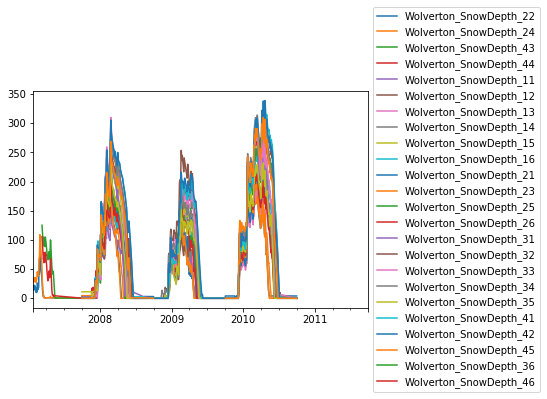

In [61]:
indexUnique = pd.date_range(str(prep.index[0]), str(prep.index[-1]))  
ready_columns = pd.unique(prep.columns)  
siteList = ready_columns
nan_values = np.nan*np.ones([len(indexUnique),len(ready_columns)])
df = pd.DataFrame(nan_values, index=indexUnique, columns = ready_columns) 

plt.figure(figsize=(10,4))
for i in np.arange(len(ready_columns)):  
    print(siteList[i])            
    site = siteList[i]     
    tab = prep[site]

    for j in np.arange(len(prep)):  
        df.loc[tab.index[j]][ready_columns[i]] = tab[j]   # to mm 
            
SnowDepth = copy.deepcopy(df)
SnowDepth.plot()
plt.gca().legend(loc='center left', bbox_to_anchor=(1, 0.5))
SnowDepth.head(2)

### 10. VaporPressure

### 11. SoilMoisture

In [50]:
# 1. Panther
df_lst=[]
for i in range(len(linklist_Panther)):
    link = linklist_Panther[i]
    print(2005 + i)
    data = pd.read_csv(link,index_col = "TIMESTAMP",parse_dates = True, infer_datetime_format = True, header = 0)  
    var = copy.deepcopy(data[['VW_Avg','VW_2_Avg','VW_3_Avg','VW_4_Avg','VW_20_Avg']])
    var.columns = ['Panther_SoilMoisture_1','Panther_SoilMoisture_2','Panther_SoilMoisture_3',
                   'Panther_SoilMoisture_4','Panther_SoilMoisture_5']
    var = threC(var,'SoilMoisture')
    var.index = pd.to_datetime(var.index)
    display(var.head(2))
    df_lst.append(var)
    
prep1=aggre_and_comb_daily(df_lst, axis=0, func = "mean") 

2005


Panther_SoilMoisture_1  Panther_SoilMoisture_2  \
TIMESTAMP                                                             
2005-10-01 00:00:00                     NaN                     NaN   
2005-10-01 01:00:00                     NaN                     NaN   

                     Panther_SoilMoisture_3  Panther_SoilMoisture_4  \
TIMESTAMP                                                             
2005-10-01 00:00:00                     NaN                     NaN   
2005-10-01 01:00:00                     NaN                     NaN   

                     Panther_SoilMoisture_5  
TIMESTAMP                                    
2005-10-01 00:00:00                     NaN  
2005-10-01 01:00:00                     NaN

2006


Panther_SoilMoisture_1  Panther_SoilMoisture_2  \
TIMESTAMP                                                             
2006-10-01 00:00:00                     NaN                     NaN   
2006-10-01 01:00:00                     NaN                     NaN   

                     Panther_SoilMoisture_3  Panther_SoilMoisture_4  \
TIMESTAMP                                                             
2006-10-01 00:00:00                     NaN                     NaN   
2006-10-01 01:00:00                     NaN                     NaN   

                     Panther_SoilMoisture_5  
TIMESTAMP                                    
2006-10-01 00:00:00                     NaN  
2006-10-01 01:00:00                     NaN

2007


Panther_SoilMoisture_1  Panther_SoilMoisture_2  \
TIMESTAMP                                                             
2007-10-01 00:00:00                    0.04                   0.049   
2007-10-01 01:00:00                    0.04                   0.050   

                     Panther_SoilMoisture_3  Panther_SoilMoisture_4  \
TIMESTAMP                                                             
2007-10-01 00:00:00                   0.008                   0.046   
2007-10-01 01:00:00                   0.008                   0.046   

                     Panther_SoilMoisture_5  
TIMESTAMP                                    
2007-10-01 00:00:00                     NaN  
2007-10-01 01:00:00                     NaN

2008


Panther_SoilMoisture_1  Panther_SoilMoisture_2  \
TIMESTAMP                                                             
2008-10-01 00:00:00                    0.04                   0.042   
2008-10-01 01:00:00                    0.04                   0.042   

                     Panther_SoilMoisture_3  Panther_SoilMoisture_4  \
TIMESTAMP                                                             
2008-10-01 00:00:00                   0.002                    0.03   
2008-10-01 01:00:00                   0.002                    0.03   

                     Panther_SoilMoisture_5  
TIMESTAMP                                    
2008-10-01 00:00:00                   0.033  
2008-10-01 01:00:00                   0.033

2009


Panther_SoilMoisture_1  Panther_SoilMoisture_2  \
TIMESTAMP                                                             
2009-10-01 00:00:00                     NaN                   0.043   
2009-10-01 01:00:00                     NaN                   0.043   

                     Panther_SoilMoisture_3  Panther_SoilMoisture_4  \
TIMESTAMP                                                             
2009-10-01 00:00:00                   0.002                   0.032   
2009-10-01 01:00:00                   0.002                   0.032   

                     Panther_SoilMoisture_5  
TIMESTAMP                                    
2009-10-01 00:00:00                     NaN  
2009-10-01 01:00:00                     NaN

2010


Panther_SoilMoisture_1  Panther_SoilMoisture_2  \
TIMESTAMP                                                             
2010-10-01 00:00:00                   0.044                   0.043   
2010-10-01 01:00:00                   0.044                   0.043   

                     Panther_SoilMoisture_3  Panther_SoilMoisture_4  \
TIMESTAMP                                                             
2010-10-01 00:00:00                   0.002                   0.035   
2010-10-01 01:00:00                   0.002                   0.035   

                     Panther_SoilMoisture_5  
TIMESTAMP                                    
2010-10-01 00:00:00                    0.03  
2010-10-01 01:00:00                    0.03

2011


Panther_SoilMoisture_1  Panther_SoilMoisture_2  \
TIMESTAMP                                                             
2011-10-01 00:00:00                     NaN                   0.045   
2011-10-01 01:00:00                     NaN                   0.045   

                     Panther_SoilMoisture_3  Panther_SoilMoisture_4  \
TIMESTAMP                                                             
2011-10-01 00:00:00                   0.002                   0.039   
2011-10-01 01:00:00                   0.002                   0.039   

                     Panther_SoilMoisture_5  
TIMESTAMP                                    
2011-10-01 00:00:00                   0.034  
2011-10-01 01:00:00                   0.034

2012


Panther_SoilMoisture_1  Panther_SoilMoisture_2  \
TIMESTAMP                                                             
2012-10-01 00:00:00                     NaN                   0.042   
2012-10-01 01:00:00                     NaN                   0.042   

                     Panther_SoilMoisture_3  Panther_SoilMoisture_4  \
TIMESTAMP                                                             
2012-10-01 00:00:00                   0.002                   0.039   
2012-10-01 01:00:00                   0.002                   0.039   

                     Panther_SoilMoisture_5  
TIMESTAMP                                    
2012-10-01 00:00:00                     NaN  
2012-10-01 01:00:00                     NaN

2013


Panther_SoilMoisture_1  Panther_SoilMoisture_2  \
TIMESTAMP                                                             
2013-10-01 00:00:00                     NaN                     NaN   
2013-10-01 01:00:00                     NaN                     NaN   

                     Panther_SoilMoisture_3  Panther_SoilMoisture_4  \
TIMESTAMP                                                             
2013-10-01 00:00:00                   0.002                   0.036   
2013-10-01 01:00:00                   0.002                   0.036   

                     Panther_SoilMoisture_5  
TIMESTAMP                                    
2013-10-01 00:00:00                     NaN  
2013-10-01 01:00:00                     NaN

2014


Panther_SoilMoisture_1  Panther_SoilMoisture_2  \
TIMESTAMP                                                             
2014-10-01 00:00:00                     NaN                     NaN   
2014-10-01 01:00:00                     NaN                     NaN   

                     Panther_SoilMoisture_3  Panther_SoilMoisture_4  \
TIMESTAMP                                                             
2014-10-01 00:00:00                   0.002                   0.069   
2014-10-01 01:00:00                   0.002                   0.069   

                     Panther_SoilMoisture_5  
TIMESTAMP                                    
2014-10-01 00:00:00                     NaN  
2014-10-01 01:00:00                     NaN

2015


Panther_SoilMoisture_1  Panther_SoilMoisture_2  \
TIMESTAMP                                                             
2015-10-01 00:00:00                     NaN                     NaN   
2015-10-01 01:00:00                     NaN                     NaN   

                     Panther_SoilMoisture_3  Panther_SoilMoisture_4  \
TIMESTAMP                                                             
2015-10-01 00:00:00                   0.003                   0.036   
2015-10-01 01:00:00                   0.003                   0.036   

                     Panther_SoilMoisture_5  
TIMESTAMP                                    
2015-10-01 00:00:00                     NaN  
2015-10-01 01:00:00                     NaN

2016


Panther_SoilMoisture_1  Panther_SoilMoisture_2  \
TIMESTAMP                                                             
2016-10-01 00:00:00                     NaN                     NaN   
2016-10-01 01:00:00                     NaN                     NaN   

                     Panther_SoilMoisture_3  Panther_SoilMoisture_4  \
TIMESTAMP                                                             
2016-10-01 00:00:00                   0.002                   0.035   
2016-10-01 01:00:00                   0.002                   0.035   

                     Panther_SoilMoisture_5  
TIMESTAMP                                    
2016-10-01 00:00:00                     NaN  
2016-10-01 01:00:00                     NaN

['Panther_SoilMoisture_2', datetime.date(2007, 7, 1)]
nan ratio is 0.08333333333333333 , groupby value is 0.058500000000000024
['Panther_SoilMoisture_1', datetime.date(2008, 1, 13)]
nan ratio is 0.08333333333333333 , groupby value is 0.03831818181818183
['Panther_SoilMoisture_3', datetime.date(2008, 1, 13)]
nan ratio is 0.08333333333333333 , groupby value is 0.004045454545454547
['Panther_SoilMoisture_4', datetime.date(2008, 1, 13)]
nan ratio is 0.08333333333333333 , groupby value is 0.04495454545454547
['Panther_SoilMoisture_5', datetime.date(2008, 1, 13)]
nan ratio is 0.08333333333333333 , groupby value is 0.04495454545454547
['Panther_SoilMoisture_1', datetime.date(2009, 5, 25)]
nan ratio is 0.041666666666666664 , groupby value is 0.14617391304347824
['Panther_SoilMoisture_2', datetime.date(2009, 5, 25)]
nan ratio is 0.041666666666666664 , groupby value is 0.12526086956521737
['Panther_SoilMoisture_4', datetime.date(2009, 5, 25)]
nan ratio is 0.041666666666666664 , groupby value is 

Panther_SoilMoisture_1 Panther_SoilMoisture_2  \
DateTime                                                   
2005-10-01                    NaN                    NaN   
2005-10-02                    NaN                    NaN   

           Panther_SoilMoisture_3 Panther_SoilMoisture_4  \
DateTime                                                   
2005-10-01                    NaN                    NaN   
2005-10-02                    NaN                    NaN   

           Panther_SoilMoisture_5  
DateTime                           
2005-10-01                    NaN  
2005-10-02                    NaN

Panther_SoilMoisture_1 Panther_SoilMoisture_2  \
DateTime                                                   
2017-09-29                    NaN                    NaN   
2017-09-30                    NaN                    NaN   

           Panther_SoilMoisture_3 Panther_SoilMoisture_4  \
DateTime                                                   
2017-09-29                    NaN                    NaN   
2017-09-30                    NaN                    NaN   

           Panther_SoilMoisture_5  
DateTime                           
2017-09-29                    NaN  
2017-09-30                    NaN

In [51]:
# 2. Wolverton
linklist_Soil = ['https://eng.ucmerced.edu/snsjho/files/MHWG/Field/SEKI/Wolverton/Site_1/Soil_moisture_logger/level_1/Site1_soil_wy2007.csv',
                'https://eng.ucmerced.edu/snsjho/files/MHWG/Field/SEKI/Wolverton/Site_1/Soil_moisture_logger/level_1/Site1_soil_wy2008.csv',
                'https://eng.ucmerced.edu/snsjho/files/MHWG/Field/SEKI/Wolverton/Site_1/Soil_moisture_logger/level_1/Site1_soil_wy2009.csv',
                'https://eng.ucmerced.edu/snsjho/files/MHWG/Field/SEKI/Wolverton/Site_1/Soil_moisture_logger/level_1/Site1_soil_wy2010.csv',
                'https://eng.ucmerced.edu/snsjho/files/MHWG/Field/SEKI/Wolverton/Site_1/Soil_moisture_logger/level_1/Site1_soil_wy2011.csv',
                'https://eng.ucmerced.edu/snsjho/files/MHWG/Field/SEKI/Wolverton/Site_1/Soil_moisture_logger/level_1/Site1_soil_wy2012.csv',
                'https://eng.ucmerced.edu/snsjho/files/MHWG/Field/SEKI/Wolverton/Site_1/Soil_moisture_logger/level_1/WaterYear_2012_2013_Site1.csv',
                 'https://eng.ucmerced.edu/snsjho/files/MHWG/Field/SEKI/Wolverton/Site_1/Soil_moisture_logger/level_1/WaterYear_2013_2014_Site1.csv',
                 'https://eng.ucmerced.edu/snsjho/files/MHWG/Field/SEKI/Wolverton/Site_1/Soil_moisture_logger/level_1/WaterYear_2014_2015_Site1.csv',
                 'https://eng.ucmerced.edu/snsjho/files/MHWG/Field/SEKI/Wolverton/Site_1/Soil_moisture_logger/level_1/WaterYear_2015_2016_Site1.csv',
                 'https://eng.ucmerced.edu/snsjho/files/MHWG/Field/SEKI/Wolverton/Site_1/Soil_moisture_logger/level_1/WaterYear_2016_2017_Site1.csv'
                ]
df_lst=[]
for i in range(len(linklist_Soil)):
    link = linklist_Soil[i]
    print(i)
    data = pd.read_csv(link,index_col = "TIMESTAMP",parse_dates = True, infer_datetime_format = True, header = 0)  
    if i in [3,4,6,7,8,9,10]:
        var = copy.deepcopy(data[['VW_Avg(1)','VW_Avg(2)','VW_Avg(3)','VW_Avg(4)','VW_Avg(5)','VW_Avg(6)',
                                 'VW_Avg(7)','VW_Avg(8)','VW_Avg(9)','VW_Avg(10)','VW_Avg(11)']])
        var.columns = ['Wolverton_SoilMoisture_1','Wolverton_SoilMoisture_2','Wolverton_SoilMoisture_3','Wolverton_SoilMoisture_4'
                      ,'Wolverton_SoilMoisture_5','Wolverton_SoilMoisture_6','Wolverton_SoilMoisture_7','Wolverton_SoilMoisture_8'
                      ,'Wolverton_SoilMoisture_9','Wolverton_SoilMoisture_10','Wolverton_SoilMoisture_11']
        
    elif i in [5]:
        var = copy.deepcopy(data[['VW_Avg(1)','VW_Avg(2)','VW_Avg(3)']])
        var.columns = ['Wolverton_SoilMoisture_1','Wolverton_SoilMoisture_2','Wolverton_SoilMoisture_3']
        
    else: 
        var = copy.deepcopy(data[['VW_Avg(1)','VW_Avg(2)','VW_Avg(3)','VW_Avg(4)','VW_Avg(5)','VW_Avg(6)',
                                 'VW_Avg(7)','VW_Avg(8)','VW_Avg(9)','VW_Avg(10)','VW_Avg(11)','VW_Avg(12)']])
        var.columns = ['Wolverton_SoilMoisture_1','Wolverton_SoilMoisture_2','Wolverton_SoilMoisture_3','Wolverton_SoilMoisture_4'
                      ,'Wolverton_SoilMoisture_5','Wolverton_SoilMoisture_6','Wolverton_SoilMoisture_7','Wolverton_SoilMoisture_8'
                      ,'Wolverton_SoilMoisture_9','Wolverton_SoilMoisture_10','Wolverton_SoilMoisture_11','Wolverton_SoilMoisture_12']                
    
    var = threC(var,'SoilMoisture')
    var.index = pd.to_datetime(var.index)
    display(var.head(2))
    df_lst.append(var)
    
prep2=aggre_and_comb_daily(df_lst, axis=0, func = "mean") 

0


Wolverton_SoilMoisture_1  Wolverton_SoilMoisture_2  \
TIMESTAMP                                                                 
2006-10-01 00:00:00                       NaN                       NaN   
2006-10-01 01:00:00                       NaN                       NaN   

                     Wolverton_SoilMoisture_3  Wolverton_SoilMoisture_4  \
TIMESTAMP                                                                 
2006-10-01 00:00:00                       NaN                       NaN   
2006-10-01 01:00:00                       NaN                       NaN   

                     Wolverton_SoilMoisture_5  Wolverton_SoilMoisture_6  \
TIMESTAMP                                                                 
2006-10-01 00:00:00                       NaN                       NaN   
2006-10-01 01:00:00                       NaN                       NaN   

                     Wolverton_SoilMoisture_7  Wolverton_SoilMoisture_8  \
TIMESTAMP                                                                 
2006-10-01 00:00:00                       NaN                       NaN   
2006-10-01 01:00:00                       NaN                       NaN   

                     Wolverton_SoilMoisture_9  Wolverton_SoilMoisture_10  \
TIMESTAMP                                                                  
2006-10-01 00:00:00                       NaN                        NaN   
2006-10-01 01:00:00                       NaN                        NaN   

                     Wolverton_SoilMoisture_11  Wolverton_SoilMoisture_12  
TIMESTAMP                                                                  
2006-10-01 00:00:00                        NaN                        NaN  
2006-10-01 01:00:00                        NaN                        NaN

1


Wolverton_SoilMoisture_1  Wolverton_SoilMoisture_2  \
TIMESTAMP                                                                 
2007-10-01 00:00:00                     0.043                     0.038   
2007-10-01 01:00:00                     0.043                     0.038   

                     Wolverton_SoilMoisture_3  Wolverton_SoilMoisture_4  \
TIMESTAMP                                                                 
2007-10-01 00:00:00                     0.061                     0.047   
2007-10-01 01:00:00                     0.061                     0.047   

                     Wolverton_SoilMoisture_5  Wolverton_SoilMoisture_6  \
TIMESTAMP                                                                 
2007-10-01 00:00:00                     0.022                     0.048   
2007-10-01 01:00:00                     0.022                     0.047   

                     Wolverton_SoilMoisture_7  Wolverton_SoilMoisture_8  \
TIMESTAMP                                                                 
2007-10-01 00:00:00                     0.039                     0.054   
2007-10-01 01:00:00                     0.039                     0.054   

                     Wolverton_SoilMoisture_9  Wolverton_SoilMoisture_10  \
TIMESTAMP                                                                  
2007-10-01 00:00:00                     0.059                      0.046   
2007-10-01 01:00:00                     0.059                      0.046   

                     Wolverton_SoilMoisture_11  Wolverton_SoilMoisture_12  
TIMESTAMP                                                                  
2007-10-01 00:00:00                      0.035                        NaN  
2007-10-01 01:00:00                      0.034                        NaN

2


Wolverton_SoilMoisture_1  Wolverton_SoilMoisture_2  \
TIMESTAMP                                                                 
2008-10-01 00:00:00                     0.046                     0.041   
2008-10-01 01:00:00                     0.046                     0.041   

                     Wolverton_SoilMoisture_3  Wolverton_SoilMoisture_4  \
TIMESTAMP                                                                 
2008-10-01 00:00:00                     0.039                     0.049   
2008-10-01 01:00:00                     0.039                     0.049   

                     Wolverton_SoilMoisture_5  Wolverton_SoilMoisture_6  \
TIMESTAMP                                                                 
2008-10-01 00:00:00                     0.041                     0.043   
2008-10-01 01:00:00                     0.041                     0.043   

                     Wolverton_SoilMoisture_7  Wolverton_SoilMoisture_8  \
TIMESTAMP                                                                 
2008-10-01 00:00:00                      0.04                      0.06   
2008-10-01 01:00:00                      0.04                      0.06   

                     Wolverton_SoilMoisture_9  Wolverton_SoilMoisture_10  \
TIMESTAMP                                                                  
2008-10-01 00:00:00                     0.055                      0.049   
2008-10-01 01:00:00                     0.055                      0.049   

                     Wolverton_SoilMoisture_11  Wolverton_SoilMoisture_12  
TIMESTAMP                                                                  
2008-10-01 00:00:00                      0.036                        NaN  
2008-10-01 01:00:00                      0.036                        NaN

3


Wolverton_SoilMoisture_1  Wolverton_SoilMoisture_2  \
TIMESTAMP                                                                 
2009-10-01 00:00:00                     0.045                     0.042   
2009-10-01 01:00:00                     0.045                     0.042   

                     Wolverton_SoilMoisture_3  Wolverton_SoilMoisture_4  \
TIMESTAMP                                                                 
2009-10-01 00:00:00                     0.039                     0.049   
2009-10-01 01:00:00                     0.039                     0.049   

                     Wolverton_SoilMoisture_5  Wolverton_SoilMoisture_6  \
TIMESTAMP                                                                 
2009-10-01 00:00:00                     0.029                     0.043   
2009-10-01 01:00:00                     0.028                     0.043   

                     Wolverton_SoilMoisture_7  Wolverton_SoilMoisture_8  \
TIMESTAMP                                                                 
2009-10-01 00:00:00                     0.039                     0.059   
2009-10-01 01:00:00                     0.039                     0.059   

                     Wolverton_SoilMoisture_9  Wolverton_SoilMoisture_10  \
TIMESTAMP                                                                  
2009-10-01 00:00:00                     0.054                      0.051   
2009-10-01 01:00:00                     0.054                      0.051   

                     Wolverton_SoilMoisture_11  
TIMESTAMP                                       
2009-10-01 00:00:00                      0.036  
2009-10-01 01:00:00                      0.036

4


Wolverton_SoilMoisture_1  Wolverton_SoilMoisture_2  \
TIMESTAMP                                                                 
2010-10-01 00:00:00                     0.045                     0.044   
2010-10-01 01:00:00                     0.045                     0.044   

                     Wolverton_SoilMoisture_3  Wolverton_SoilMoisture_4  \
TIMESTAMP                                                                 
2010-10-01 00:00:00                      0.04                     0.051   
2010-10-01 01:00:00                      0.04                     0.051   

                     Wolverton_SoilMoisture_5  Wolverton_SoilMoisture_6  \
TIMESTAMP                                                                 
2010-10-01 00:00:00                     0.026                     0.045   
2010-10-01 01:00:00                     0.026                     0.045   

                     Wolverton_SoilMoisture_7  Wolverton_SoilMoisture_8  \
TIMESTAMP                                                                 
2010-10-01 00:00:00                     0.041                     0.062   
2010-10-01 01:00:00                     0.041                     0.062   

                     Wolverton_SoilMoisture_9  Wolverton_SoilMoisture_10  \
TIMESTAMP                                                                  
2010-10-01 00:00:00                     0.055                      0.053   
2010-10-01 01:00:00                     0.055                      0.053   

                     Wolverton_SoilMoisture_11  
TIMESTAMP                                       
2010-10-01 00:00:00                      0.037  
2010-10-01 01:00:00                      0.037

5


Wolverton_SoilMoisture_1  Wolverton_SoilMoisture_2  \
TIMESTAMP                                                                 
2011-10-01 00:00:00                       NaN                       NaN   
2011-10-01 00:15:00                       NaN                       NaN   

                     Wolverton_SoilMoisture_3  
TIMESTAMP                                      
2011-10-01 00:00:00                       NaN  
2011-10-01 00:15:00                       NaN

6


Wolverton_SoilMoisture_1  Wolverton_SoilMoisture_2  \
TIMESTAMP                                                                 
2012-10-01 00:00:00                     0.044                     0.042   
2012-10-01 01:00:00                     0.044                     0.043   

                     Wolverton_SoilMoisture_3  Wolverton_SoilMoisture_4  \
TIMESTAMP                                                                 
2012-10-01 00:00:00                     0.039                     0.049   
2012-10-01 01:00:00                     0.038                     0.049   

                     Wolverton_SoilMoisture_5  Wolverton_SoilMoisture_6  \
TIMESTAMP                                                                 
2012-10-01 00:00:00                     0.022                     0.045   
2012-10-01 01:00:00                     0.022                     0.045   

                     Wolverton_SoilMoisture_7  Wolverton_SoilMoisture_8  \
TIMESTAMP                                                                 
2012-10-01 00:00:00                     0.038                      0.06   
2012-10-01 01:00:00                     0.038                      0.06   

                     Wolverton_SoilMoisture_9  Wolverton_SoilMoisture_10  \
TIMESTAMP                                                                  
2012-10-01 00:00:00                     0.053                      0.054   
2012-10-01 01:00:00                     0.052                      0.054   

                     Wolverton_SoilMoisture_11  
TIMESTAMP                                       
2012-10-01 00:00:00                      0.035  
2012-10-01 01:00:00                      0.035

7


Wolverton_SoilMoisture_1  Wolverton_SoilMoisture_2  \
TIMESTAMP                                                                 
2013-10-01 00:00:00                      0.04                      0.04   
2013-10-01 01:00:00                      0.04                      0.04   

                     Wolverton_SoilMoisture_3  Wolverton_SoilMoisture_4  \
TIMESTAMP                                                                 
2013-10-01 00:00:00                     0.039                     0.048   
2013-10-01 01:00:00                     0.039                     0.048   

                     Wolverton_SoilMoisture_5  Wolverton_SoilMoisture_6  \
TIMESTAMP                                                                 
2013-10-01 00:00:00                     0.019                     0.044   
2013-10-01 01:00:00                     0.019                     0.044   

                     Wolverton_SoilMoisture_7  Wolverton_SoilMoisture_8  \
TIMESTAMP                                                                 
2013-10-01 00:00:00                     0.041                     0.059   
2013-10-01 01:00:00                     0.041                     0.059   

                     Wolverton_SoilMoisture_9  Wolverton_SoilMoisture_10  \
TIMESTAMP                                                                  
2013-10-01 00:00:00                      0.05                      0.053   
2013-10-01 01:00:00                      0.05                      0.053   

                     Wolverton_SoilMoisture_11  
TIMESTAMP                                       
2013-10-01 00:00:00                      0.034  
2013-10-01 01:00:00                      0.034

8


Wolverton_SoilMoisture_1  Wolverton_SoilMoisture_2  \
TIMESTAMP                                                                 
2014-10-01 00:00:00                     0.039                      0.04   
2014-10-01 01:00:00                     0.039                      0.04   

                     Wolverton_SoilMoisture_3  Wolverton_SoilMoisture_4  \
TIMESTAMP                                                                 
2014-10-01 00:00:00                     0.059                     0.077   
2014-10-01 01:00:00                     0.059                     0.077   

                     Wolverton_SoilMoisture_5  Wolverton_SoilMoisture_6  \
TIMESTAMP                                                                 
2014-10-01 00:00:00                     0.025                     0.043   
2014-10-01 01:00:00                     0.025                     0.043   

                     Wolverton_SoilMoisture_7  Wolverton_SoilMoisture_8  \
TIMESTAMP                                                                 
2014-10-01 00:00:00                      0.04                     0.058   
2014-10-01 01:00:00                      0.04                     0.058   

                     Wolverton_SoilMoisture_9  Wolverton_SoilMoisture_10  \
TIMESTAMP                                                                  
2014-10-01 00:00:00                     0.049                      0.052   
2014-10-01 01:00:00                     0.049                      0.052   

                     Wolverton_SoilMoisture_11  
TIMESTAMP                                       
2014-10-01 00:00:00                      0.033  
2014-10-01 01:00:00                      0.033

9


Wolverton_SoilMoisture_1  Wolverton_SoilMoisture_2  \
TIMESTAMP                                                                 
2015-10-01 00:00:00                     0.039                     0.041   
2015-10-01 01:00:00                     0.039                     0.041   

                     Wolverton_SoilMoisture_3  Wolverton_SoilMoisture_4  \
TIMESTAMP                                                                 
2015-10-01 00:00:00                     0.038                     0.048   
2015-10-01 01:00:00                     0.038                     0.048   

                     Wolverton_SoilMoisture_5  Wolverton_SoilMoisture_6  \
TIMESTAMP                                                                 
2015-10-01 00:00:00                     0.026                     0.044   
2015-10-01 01:00:00                     0.026                     0.044   

                     Wolverton_SoilMoisture_7  Wolverton_SoilMoisture_8  \
TIMESTAMP                                                                 
2015-10-01 00:00:00                     0.040                     0.059   
2015-10-01 01:00:00                     0.039                     0.059   

                     Wolverton_SoilMoisture_9  Wolverton_SoilMoisture_10  \
TIMESTAMP                                                                  
2015-10-01 00:00:00                     0.048                      0.053   
2015-10-01 01:00:00                     0.048                      0.053   

                     Wolverton_SoilMoisture_11  
TIMESTAMP                                       
2015-10-01 00:00:00                      0.034  
2015-10-01 01:00:00                      0.034

10


Wolverton_SoilMoisture_1  Wolverton_SoilMoisture_2  \
TIMESTAMP                                                                 
2016-10-01 00:00:00                       NaN                       NaN   
2016-10-01 01:00:00                       NaN                       NaN   

                     Wolverton_SoilMoisture_3  Wolverton_SoilMoisture_4  \
TIMESTAMP                                                                 
2016-10-01 00:00:00                       NaN                       NaN   
2016-10-01 01:00:00                       NaN                       NaN   

                     Wolverton_SoilMoisture_5  Wolverton_SoilMoisture_6  \
TIMESTAMP                                                                 
2016-10-01 00:00:00                       NaN                       NaN   
2016-10-01 01:00:00                       NaN                       NaN   

                     Wolverton_SoilMoisture_7  Wolverton_SoilMoisture_8  \
TIMESTAMP                                                                 
2016-10-01 00:00:00                       NaN                       NaN   
2016-10-01 01:00:00                       NaN                       NaN   

                     Wolverton_SoilMoisture_9  Wolverton_SoilMoisture_10  \
TIMESTAMP                                                                  
2016-10-01 00:00:00                       NaN                        NaN   
2016-10-01 01:00:00                       NaN                        NaN   

                     Wolverton_SoilMoisture_11  
TIMESTAMP                                       
2016-10-01 00:00:00                        NaN  
2016-10-01 01:00:00                        NaN

['Wolverton_SoilMoisture_1', datetime.date(2007, 7, 25)]
nan ratio is 0.041666666666666664 , groupby value is 0.044956521739130444
['Wolverton_SoilMoisture_2', datetime.date(2007, 7, 25)]
nan ratio is 0.041666666666666664 , groupby value is 0.040043478260869576
['Wolverton_SoilMoisture_3', datetime.date(2007, 7, 25)]
nan ratio is 0.041666666666666664 , groupby value is 0.03669565217391305
['Wolverton_SoilMoisture_4', datetime.date(2007, 7, 25)]
nan ratio is 0.041666666666666664 , groupby value is 0.052173913043478286
['Wolverton_SoilMoisture_5', datetime.date(2007, 7, 25)]
nan ratio is 0.041666666666666664 , groupby value is 0.04373913043478262
['Wolverton_SoilMoisture_6', datetime.date(2007, 7, 25)]
nan ratio is 0.041666666666666664 , groupby value is 0.04400000000000001
['Wolverton_SoilMoisture_7', datetime.date(2007, 7, 25)]
nan ratio is 0.041666666666666664 , groupby value is 0.037565217391304355
['Wolverton_SoilMoisture_8', datetime.date(2007, 7, 25)]
nan ratio is 0.04166666666666

['Wolverton_SoilMoisture_10', datetime.date(2013, 11, 25)]
nan ratio is 0.08333333333333333 , groupby value is 0.05068181818181819
['Wolverton_SoilMoisture_11', datetime.date(2013, 11, 25)]
nan ratio is 0.08333333333333333 , groupby value is 0.03186363636363638
The final table is:


Wolverton_SoilMoisture_1 Wolverton_SoilMoisture_2  \
DateTime                                                       
2006-10-01                      NaN                      NaN   
2006-10-02                      NaN                      NaN   

           Wolverton_SoilMoisture_3 Wolverton_SoilMoisture_4  \
DateTime                                                       
2006-10-01                      NaN                      NaN   
2006-10-02                      NaN                      NaN   

           Wolverton_SoilMoisture_5 Wolverton_SoilMoisture_6  \
DateTime                                                       
2006-10-01                      NaN                      NaN   
2006-10-02                      NaN                      NaN   

           Wolverton_SoilMoisture_7 Wolverton_SoilMoisture_8  \
DateTime                                                       
2006-10-01                      NaN                      NaN   
2006-10-02                      NaN                      NaN   

           Wolverton_SoilMoisture_9 Wolverton_SoilMoisture_10  \
DateTime                                                        
2006-10-01                      NaN                       NaN   
2006-10-02                      NaN                       NaN   

           Wolverton_SoilMoisture_11 Wolverton_SoilMoisture_12  
DateTime                                                        
2006-10-01                       NaN                       NaN  
2006-10-02                       NaN                       NaN

Wolverton_SoilMoisture_1 Wolverton_SoilMoisture_2  \
DateTime                                                       
2017-09-29                      NaN                      NaN   
2017-09-30                      NaN                      NaN   

           Wolverton_SoilMoisture_3 Wolverton_SoilMoisture_4  \
DateTime                                                       
2017-09-29                      NaN                      NaN   
2017-09-30                      NaN                      NaN   

           Wolverton_SoilMoisture_5 Wolverton_SoilMoisture_6  \
DateTime                                                       
2017-09-29                      NaN                      NaN   
2017-09-30                      NaN                      NaN   

           Wolverton_SoilMoisture_7 Wolverton_SoilMoisture_8  \
DateTime                                                       
2017-09-29                      NaN                      NaN   
2017-09-30                      NaN                      NaN   

           Wolverton_SoilMoisture_9 Wolverton_SoilMoisture_10  \
DateTime                                                        
2017-09-29                      NaN                       NaN   
2017-09-30                      NaN                       NaN   

           Wolverton_SoilMoisture_11 Wolverton_SoilMoisture_12  
DateTime                                                        
2017-09-29                       NaN                       NaN  
2017-09-30                       NaN                       NaN

In [52]:
prep = aggre_and_comb_daily([prep1,prep2], axis=1, func = "mean") 

The final table is:


Panther_SoilMoisture_1 Panther_SoilMoisture_2  \
2005-10-01                    NaN                    NaN   
2005-10-02                    NaN                    NaN   

           Panther_SoilMoisture_3 Panther_SoilMoisture_4  \
2005-10-01                    NaN                    NaN   
2005-10-02                    NaN                    NaN   

           Panther_SoilMoisture_5 Wolverton_SoilMoisture_1  \
2005-10-01                    NaN                      NaN   
2005-10-02                    NaN                      NaN   

           Wolverton_SoilMoisture_2 Wolverton_SoilMoisture_3  \
2005-10-01                      NaN                      NaN   
2005-10-02                      NaN                      NaN   

           Wolverton_SoilMoisture_4 Wolverton_SoilMoisture_5  \
2005-10-01                      NaN                      NaN   
2005-10-02                      NaN                      NaN   

           Wolverton_SoilMoisture_6 Wolverton_SoilMoisture_7  \
2005-10-01                      NaN                      NaN   
2005-10-02                      NaN                      NaN   

           Wolverton_SoilMoisture_8 Wolverton_SoilMoisture_9  \
2005-10-01                      NaN                      NaN   
2005-10-02                      NaN                      NaN   

           Wolverton_SoilMoisture_10 Wolverton_SoilMoisture_11  \
2005-10-01                       NaN                       NaN   
2005-10-02                       NaN                       NaN   

           Wolverton_SoilMoisture_12  
2005-10-01                       NaN  
2005-10-02                       NaN

Panther_SoilMoisture_1 Panther_SoilMoisture_2  \
2017-09-29                    NaN                    NaN   
2017-09-30                    NaN                    NaN   

           Panther_SoilMoisture_3 Panther_SoilMoisture_4  \
2017-09-29                    NaN                    NaN   
2017-09-30                    NaN                    NaN   

           Panther_SoilMoisture_5 Wolverton_SoilMoisture_1  \
2017-09-29                    NaN                      NaN   
2017-09-30                    NaN                      NaN   

           Wolverton_SoilMoisture_2 Wolverton_SoilMoisture_3  \
2017-09-29                      NaN                      NaN   
2017-09-30                      NaN                      NaN   

           Wolverton_SoilMoisture_4 Wolverton_SoilMoisture_5  \
2017-09-29                      NaN                      NaN   
2017-09-30                      NaN                      NaN   

           Wolverton_SoilMoisture_6 Wolverton_SoilMoisture_7  \
2017-09-29                      NaN                      NaN   
2017-09-30                      NaN                      NaN   

           Wolverton_SoilMoisture_8 Wolverton_SoilMoisture_9  \
2017-09-29                      NaN                      NaN   
2017-09-30                      NaN                      NaN   

           Wolverton_SoilMoisture_10 Wolverton_SoilMoisture_11  \
2017-09-29                       NaN                       NaN   
2017-09-30                       NaN                       NaN   

           Wolverton_SoilMoisture_12  
2017-09-29                       NaN  
2017-09-30                       NaN

Panther_SoilMoisture_1
Panther_SoilMoisture_2
Panther_SoilMoisture_3
Panther_SoilMoisture_4
Panther_SoilMoisture_5
Wolverton_SoilMoisture_1
Wolverton_SoilMoisture_2
Wolverton_SoilMoisture_3
Wolverton_SoilMoisture_4
Wolverton_SoilMoisture_5
Wolverton_SoilMoisture_6
Wolverton_SoilMoisture_7
Wolverton_SoilMoisture_8
Wolverton_SoilMoisture_9
Wolverton_SoilMoisture_10
Wolverton_SoilMoisture_11
Wolverton_SoilMoisture_12


Panther_SoilMoisture_1  Panther_SoilMoisture_2  \
2005-10-01                     NaN                     NaN   
2005-10-02                     NaN                     NaN   

            Panther_SoilMoisture_3  Panther_SoilMoisture_4  \
2005-10-01                     NaN                     NaN   
2005-10-02                     NaN                     NaN   

            Panther_SoilMoisture_5  Wolverton_SoilMoisture_1  \
2005-10-01                     NaN                       NaN   
2005-10-02                     NaN                       NaN   

            Wolverton_SoilMoisture_2  Wolverton_SoilMoisture_3  \
2005-10-01                       NaN                       NaN   
2005-10-02                       NaN                       NaN   

            Wolverton_SoilMoisture_4  Wolverton_SoilMoisture_5  \
2005-10-01                       NaN                       NaN   
2005-10-02                       NaN                       NaN   

            Wolverton_SoilMoisture_6  Wolverton_SoilMoisture_7  \
2005-10-01                       NaN                       NaN   
2005-10-02                       NaN                       NaN   

            Wolverton_SoilMoisture_8  Wolverton_SoilMoisture_9  \
2005-10-01                       NaN                       NaN   
2005-10-02                       NaN                       NaN   

            Wolverton_SoilMoisture_10  Wolverton_SoilMoisture_11  \
2005-10-01                        NaN                        NaN   
2005-10-02                        NaN                        NaN   

            Wolverton_SoilMoisture_12  
2005-10-01                        NaN  
2005-10-02                        NaN

<Figure size 720x288 with 0 Axes>

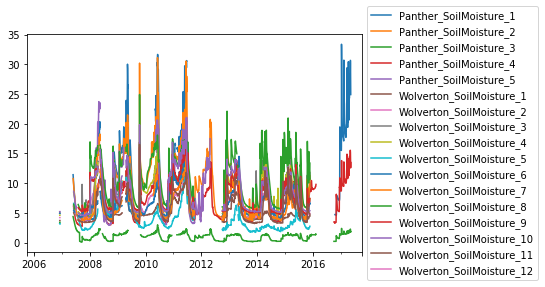

In [53]:
indexUnique = pd.date_range(str(prep.index[0]), str(prep.index[-1]))  
ready_columns = pd.unique(prep.columns)  
siteList = ready_columns
nan_values = np.nan*np.ones([len(indexUnique),len(ready_columns)])
df = pd.DataFrame(nan_values, index=indexUnique, columns = ready_columns) 

plt.figure(figsize=(10,4))
for i in np.arange(len(ready_columns)):  
    print(siteList[i])            
    site = siteList[i]     
    tab = prep[site]

    for j in np.arange(len(prep)):  
        df.loc[tab.index[j]][ready_columns[i]] = tab[j]*100 #  to %

df = threC(df,'SoilMoisture')
SoilMoisture = copy.deepcopy(df)
SoilMoisture.plot()
plt.gca().legend(loc='center left', bbox_to_anchor=(1, 0.5))
SoilMoisture.head(2)

### 12. SoilTemperature

In [68]:
# 1. Panther
df_lst=[]
for i in range(len(linklist_Panther)):
    link = linklist_Panther[i]
    print(2005 + i)
    data = pd.read_csv(link,index_col = "TIMESTAMP",parse_dates = True, infer_datetime_format = True, header = 0)  
    var = copy.deepcopy(data[['T107_C_Avg','T107_C_2_Avg','T107_C_3_Avg','T107_C_4_Avg']])
    var.columns = ['Panther_SoilTemperature_1','Panther_SoilTemperature_2','Panther_SoilTemperature_3',
                   'Panther_SoilTemperature_4']
    var = threC(var,'SoilTemperature')
    var.index = pd.to_datetime(var.index)
    display(var.head(2))
    df_lst.append(var)
    
prep1=aggre_and_comb_daily(df_lst, axis=0, func = "mean") 

2005


Panther_SoilTemperature_1  Panther_SoilTemperature_2  \
TIMESTAMP                                                                   
2005-10-01 00:00:00                        NaN                        NaN   
2005-10-01 01:00:00                        NaN                        NaN   

                     Panther_SoilTemperature_3  Panther_SoilTemperature_4  
TIMESTAMP                                                                  
2005-10-01 00:00:00                        NaN                        NaN  
2005-10-01 01:00:00                        NaN                        NaN

2006


Panther_SoilTemperature_1  Panther_SoilTemperature_2  \
TIMESTAMP                                                                   
2006-10-01 00:00:00                        NaN                        NaN   
2006-10-01 01:00:00                        NaN                        NaN   

                     Panther_SoilTemperature_3  Panther_SoilTemperature_4  
TIMESTAMP                                                                  
2006-10-01 00:00:00                        NaN                        NaN  
2006-10-01 01:00:00                        NaN                        NaN

2007


Panther_SoilTemperature_1  Panther_SoilTemperature_2  \
TIMESTAMP                                                                   
2007-10-01 00:00:00                       9.51                        9.2   
2007-10-01 01:00:00                       9.51                        9.2   

                     Panther_SoilTemperature_3  Panther_SoilTemperature_4  
TIMESTAMP                                                                  
2007-10-01 00:00:00                       8.60                       8.71  
2007-10-01 01:00:00                       8.62                       8.64

2008


Panther_SoilTemperature_1  Panther_SoilTemperature_2  \
TIMESTAMP                                                                   
2008-10-01 00:00:00                        NaN                      11.27   
2008-10-01 01:00:00                        NaN                      11.26   

                     Panther_SoilTemperature_3  Panther_SoilTemperature_4  
TIMESTAMP                                                                  
2008-10-01 00:00:00                      11.48                        NaN  
2008-10-01 01:00:00                      11.50                        NaN

2009


Panther_SoilTemperature_1  Panther_SoilTemperature_2  \
TIMESTAMP                                                                   
2009-10-01 00:00:00                      11.22                      12.03   
2009-10-01 01:00:00                      11.22                      12.01   

                     Panther_SoilTemperature_3  Panther_SoilTemperature_4  
TIMESTAMP                                                                  
2009-10-01 00:00:00                      11.93                        NaN  
2009-10-01 01:00:00                      11.92                        NaN

2010


Panther_SoilTemperature_1  Panther_SoilTemperature_2  \
TIMESTAMP                                                                   
2010-10-01 00:00:00                        NaN                      11.33   
2010-10-01 01:00:00                        NaN                      11.34   

                     Panther_SoilTemperature_3  Panther_SoilTemperature_4  
TIMESTAMP                                                                  
2010-10-01 00:00:00                      13.23                      15.17  
2010-10-01 01:00:00                      13.24                      15.09

2011


Panther_SoilTemperature_1  Panther_SoilTemperature_2  \
TIMESTAMP                                                                   
2011-10-01 00:00:00                        NaN                      11.42   
2011-10-01 01:00:00                        NaN                      11.42   

                     Panther_SoilTemperature_3  Panther_SoilTemperature_4  
TIMESTAMP                                                                  
2011-10-01 00:00:00                      12.11                      13.03  
2011-10-01 01:00:00                      12.12                      12.89

2012


Panther_SoilTemperature_1  Panther_SoilTemperature_2  \
TIMESTAMP                                                                   
2012-10-01 00:00:00                        NaN                      11.87   
2012-10-01 01:00:00                        NaN                      11.87   

                     Panther_SoilTemperature_3  Panther_SoilTemperature_4  
TIMESTAMP                                                                  
2012-10-01 00:00:00                      12.63                        NaN  
2012-10-01 01:00:00                      12.66                        NaN

2013


Panther_SoilTemperature_1  Panther_SoilTemperature_2  \
TIMESTAMP                                                                   
2013-10-01 00:00:00                      18.12                        NaN   
2013-10-01 01:00:00                      18.11                        NaN   

                     Panther_SoilTemperature_3  Panther_SoilTemperature_4  
TIMESTAMP                                                                  
2013-10-01 00:00:00                        NaN                        NaN  
2013-10-01 01:00:00                        NaN                        NaN

2014


Panther_SoilTemperature_1  Panther_SoilTemperature_2  \
TIMESTAMP                                                                   
2014-10-01 00:00:00                      14.29                        NaN   
2014-10-01 01:00:00                      14.27                        NaN   

                     Panther_SoilTemperature_3  Panther_SoilTemperature_4  
TIMESTAMP                                                                  
2014-10-01 00:00:00                       8.93                        NaN  
2014-10-01 01:00:00                       8.96                        NaN

2015


Panther_SoilTemperature_1  Panther_SoilTemperature_2  \
TIMESTAMP                                                                   
2015-10-01 00:00:00                      13.99                        NaN   
2015-10-01 01:00:00                      14.00                        NaN   

                     Panther_SoilTemperature_3  Panther_SoilTemperature_4  
TIMESTAMP                                                                  
2015-10-01 00:00:00                        NaN                        NaN  
2015-10-01 01:00:00                        NaN                        NaN

2016


Panther_SoilTemperature_1  Panther_SoilTemperature_2  \
TIMESTAMP                                                                   
2016-10-01 00:00:00                      12.52                        NaN   
2016-10-01 01:00:00                      12.52                        NaN   

                     Panther_SoilTemperature_3  Panther_SoilTemperature_4  
TIMESTAMP                                                                  
2016-10-01 00:00:00                      11.91                        NaN  
2016-10-01 01:00:00                      11.92                        NaN

['Panther_SoilTemperature_2', datetime.date(2007, 6, 1)]
nan ratio is 0.08333333333333333 , groupby value is 10.841363636363637
['Panther_SoilTemperature_3', datetime.date(2007, 6, 1)]
nan ratio is 0.041666666666666664 , groupby value is 11.576086956521742
['Panther_SoilTemperature_4', datetime.date(2007, 6, 1)]
nan ratio is 0.041666666666666664 , groupby value is 11.346086956521738
['Panther_SoilTemperature_1', datetime.date(2008, 1, 13)]
nan ratio is 0.08333333333333333 , groupby value is 3.7419090909090915
['Panther_SoilTemperature_1', datetime.date(2008, 6, 19)]
nan ratio is 0.041666666666666664 , groupby value is 9.678347826086956
['Panther_SoilTemperature_1', datetime.date(2008, 6, 20)]
nan ratio is 0.08333333333333333 , groupby value is 8.216863636363636
['Panther_SoilTemperature_1', datetime.date(2008, 6, 21)]
nan ratio is 0.08333333333333333 , groupby value is 9.222409090909093
['Panther_SoilTemperature_1', datetime.date(2008, 7, 10)]
nan ratio is 0.08333333333333333 , groupby

['Panther_SoilTemperature_3', datetime.date(2015, 4, 29)]
nan ratio is 0.08333333333333333 , groupby value is 5.306409090909091
['Panther_SoilTemperature_3', datetime.date(2015, 10, 4)]
nan ratio is 0.041666666666666664 , groupby value is 13.72817391304348
['Panther_SoilTemperature_1', datetime.date(2016, 10, 13)]
nan ratio is 0.08333333333333333 , groupby value is 11.538636363636364
The final table is:


Panther_SoilTemperature_1 Panther_SoilTemperature_2  \
DateTime                                                         
2005-10-01                       NaN                       NaN   
2005-10-02                       NaN                       NaN   

           Panther_SoilTemperature_3 Panther_SoilTemperature_4  
DateTime                                                        
2005-10-01                       NaN                       NaN  
2005-10-02                       NaN                       NaN

Panther_SoilTemperature_1 Panther_SoilTemperature_2  \
DateTime                                                         
2017-09-29                       NaN                       NaN   
2017-09-30                       NaN                       NaN   

           Panther_SoilTemperature_3 Panther_SoilTemperature_4  
DateTime                                                        
2017-09-29                       NaN                       NaN  
2017-09-30                       NaN                       NaN

In [69]:
# 2. Wolverton
df_lst=[]
for i in range(len(linklist_Soil)):
    link = linklist_Soil[i]
    print(i)
    data = pd.read_csv(link,index_col = "TIMESTAMP",parse_dates = True, infer_datetime_format = True, header = 0)  

    if i in [3,4,6,7,8,9,10]:
        var = copy.deepcopy(data[['T107_C_Avg(1)','T107_C_Avg(2)','T107_C_Avg(3)','T107_C_Avg(4)',
                                  'T107_C_Avg(5)','T107_C_Avg(6)',
                                 'T107_C_Avg(7)','T107_C_Avg(8)','T107_C_Avg(9)',
                                  'T107_C_Avg(10)','T107_C_Avg(11)']])
        var.columns = ['Wolverton_SoilTemperature_' + i.split('(')[1][:-1] for i in var.columns]
        
    elif i in [5]:
        continue # no ST data 
        
    else: 
        var = copy.deepcopy(data[['T107_C_Avg(1)','T107_C_Avg(2)','T107_C_Avg(3)','T107_C_Avg(4)',
                                  'T107_C_Avg(5)','T107_C_Avg(6)',
                                 'T107_C_Avg(7)','T107_C_Avg(8)','T107_C_Avg(9)',
                                  'T107_C_Avg(10)','T107_C_Avg(11)','T107_C_Avg(12)']])
        var.columns = ['Wolverton_SoilTemperature_' + i.split('(')[1][:-1] for i in var.columns] 
        
    var = threC(var,'SoilTemperature')
    var.index = pd.to_datetime(var.index)
    display(var.head(2))
    df_lst.append(var)
    
prep2=aggre_and_comb_daily(df_lst, axis=0, func = "mean") 

0


Wolverton_SoilTemperature_1  Wolverton_SoilTemperature_2  \
TIMESTAMP                                                                       
2006-10-01 00:00:00                          NaN                          NaN   
2006-10-01 01:00:00                          NaN                          NaN   

                     Wolverton_SoilTemperature_3  Wolverton_SoilTemperature_4  \
TIMESTAMP                                                                       
2006-10-01 00:00:00                          NaN                          NaN   
2006-10-01 01:00:00                          NaN                          NaN   

                     Wolverton_SoilTemperature_5  Wolverton_SoilTemperature_6  \
TIMESTAMP                                                                       
2006-10-01 00:00:00                          NaN                          NaN   
2006-10-01 01:00:00                          NaN                          NaN   

                     Wolverton_SoilTemperature_7  Wolverton_SoilTemperature_8  \
TIMESTAMP                                                                       
2006-10-01 00:00:00                          NaN                          NaN   
2006-10-01 01:00:00                          NaN                          NaN   

                     Wolverton_SoilTemperature_9  \
TIMESTAMP                                          
2006-10-01 00:00:00                          NaN   
2006-10-01 01:00:00                          NaN   

                     Wolverton_SoilTemperature_10  \
TIMESTAMP                                           
2006-10-01 00:00:00                           NaN   
2006-10-01 01:00:00                           NaN   

                     Wolverton_SoilTemperature_11  \
TIMESTAMP                                           
2006-10-01 00:00:00                           NaN   
2006-10-01 01:00:00                           NaN   

                     Wolverton_SoilTemperature_12  
TIMESTAMP                                          
2006-10-01 00:00:00                           NaN  
2006-10-01 01:00:00                           NaN

1


Wolverton_SoilTemperature_1  Wolverton_SoilTemperature_2  \
TIMESTAMP                                                                       
2007-10-01 00:00:00                         8.54                         9.49   
2007-10-01 01:00:00                         8.54                         9.49   

                     Wolverton_SoilTemperature_3  Wolverton_SoilTemperature_4  \
TIMESTAMP                                                                       
2007-10-01 00:00:00                        10.18                        10.02   
2007-10-01 01:00:00                        10.18                        10.02   

                     Wolverton_SoilTemperature_5  Wolverton_SoilTemperature_6  \
TIMESTAMP                                                                       
2007-10-01 00:00:00                        7.964                         8.54   
2007-10-01 01:00:00                        7.916                         8.57   

                     Wolverton_SoilTemperature_7  Wolverton_SoilTemperature_8  \
TIMESTAMP                                                                       
2007-10-01 00:00:00                         9.30                        6.900   
2007-10-01 01:00:00                         9.31                        6.878   

                     Wolverton_SoilTemperature_9  \
TIMESTAMP                                          
2007-10-01 00:00:00                        7.159   
2007-10-01 01:00:00                        7.163   

                     Wolverton_SoilTemperature_10  \
TIMESTAMP                                           
2007-10-01 00:00:00                         7.782   
2007-10-01 01:00:00                         7.786   

                     Wolverton_SoilTemperature_11  \
TIMESTAMP                                           
2007-10-01 00:00:00                          8.23   
2007-10-01 01:00:00                          8.23   

                     Wolverton_SoilTemperature_12  
TIMESTAMP                                          
2007-10-01 00:00:00                           NaN  
2007-10-01 01:00:00                           NaN

2


Wolverton_SoilTemperature_1  Wolverton_SoilTemperature_2  \
TIMESTAMP                                                                       
2008-10-01 00:00:00                        11.08                        11.27   
2008-10-01 01:00:00                        11.06                        11.27   

                     Wolverton_SoilTemperature_3  Wolverton_SoilTemperature_4  \
TIMESTAMP                                                                       
2008-10-01 00:00:00                        11.06                        10.15   
2008-10-01 01:00:00                        11.44                        10.15   

                     Wolverton_SoilTemperature_5  Wolverton_SoilTemperature_6  \
TIMESTAMP                                                                       
2008-10-01 00:00:00                        11.35                        11.11   
2008-10-01 01:00:00                        11.30                        11.14   

                     Wolverton_SoilTemperature_7  Wolverton_SoilTemperature_8  \
TIMESTAMP                                                                       
2008-10-01 00:00:00                        10.58                         9.83   
2008-10-01 01:00:00                        10.58                         9.78   

                     Wolverton_SoilTemperature_9  \
TIMESTAMP                                          
2008-10-01 00:00:00                         9.62   
2008-10-01 01:00:00                         9.62   

                     Wolverton_SoilTemperature_10  \
TIMESTAMP                                           
2008-10-01 00:00:00                          9.01   
2008-10-01 01:00:00                          9.01   

                     Wolverton_SoilTemperature_11  \
TIMESTAMP                                           
2008-10-01 00:00:00                          8.72   
2008-10-01 01:00:00                          8.72   

                     Wolverton_SoilTemperature_12  
TIMESTAMP                                          
2008-10-01 00:00:00                           NaN  
2008-10-01 01:00:00                           NaN

3


Wolverton_SoilTemperature_1  Wolverton_SoilTemperature_2  \
TIMESTAMP                                                                       
2009-10-01 00:00:00                         9.03                        11.25   
2009-10-01 01:00:00                         8.98                        11.22   

                     Wolverton_SoilTemperature_3  Wolverton_SoilTemperature_4  \
TIMESTAMP                                                                       
2009-10-01 00:00:00                        14.35                        10.76   
2009-10-01 01:00:00                        14.35                        10.75   

                     Wolverton_SoilTemperature_5  Wolverton_SoilTemperature_6  \
TIMESTAMP                                                                       
2009-10-01 00:00:00                         9.55                        10.84   
2009-10-01 01:00:00                         9.49                        10.82   

                     Wolverton_SoilTemperature_7  Wolverton_SoilTemperature_8  \
TIMESTAMP                                                                       
2009-10-01 00:00:00                        11.13                         8.87   
2009-10-01 01:00:00                        11.12                         8.83   

                     Wolverton_SoilTemperature_9  \
TIMESTAMP                                          
2009-10-01 00:00:00                         9.33   
2009-10-01 01:00:00                         9.31   

                     Wolverton_SoilTemperature_10  \
TIMESTAMP                                           
2009-10-01 00:00:00                          9.76   
2009-10-01 01:00:00                          9.74   

                     Wolverton_SoilTemperature_11  
TIMESTAMP                                          
2009-10-01 00:00:00                          9.42  
2009-10-01 01:00:00                          9.42

4


Wolverton_SoilTemperature_1  Wolverton_SoilTemperature_2  \
TIMESTAMP                                                                       
2010-10-01 00:00:00                        11.93                        11.52   
2010-10-01 01:00:00                        11.90                        11.53   

                     Wolverton_SoilTemperature_3  Wolverton_SoilTemperature_4  \
TIMESTAMP                                                                       
2010-10-01 00:00:00                        10.05                         9.36   
2010-10-01 01:00:00                        10.06                         9.37   

                     Wolverton_SoilTemperature_5  Wolverton_SoilTemperature_6  \
TIMESTAMP                                                                       
2010-10-01 00:00:00                        11.96                        11.11   
2010-10-01 01:00:00                        11.92                        11.14   

                     Wolverton_SoilTemperature_7  Wolverton_SoilTemperature_8  \
TIMESTAMP                                                                       
2010-10-01 00:00:00                         9.71                        10.80   
2010-10-01 01:00:00                         9.72                        10.79   

                     Wolverton_SoilTemperature_9  \
TIMESTAMP                                          
2010-10-01 00:00:00                        10.32   
2010-10-01 01:00:00                        10.34   

                     Wolverton_SoilTemperature_10  \
TIMESTAMP                                           
2010-10-01 00:00:00                          8.82   
2010-10-01 01:00:00                          8.84   

                     Wolverton_SoilTemperature_11  
TIMESTAMP                                          
2010-10-01 00:00:00                          8.18  
2010-10-01 01:00:00                          8.19

5
6


Wolverton_SoilTemperature_1  Wolverton_SoilTemperature_2  \
TIMESTAMP                                                                       
2012-10-01 00:00:00                        11.78                        12.08   
2012-10-01 01:00:00                        11.74                        12.09   

                     Wolverton_SoilTemperature_3  Wolverton_SoilTemperature_4  \
TIMESTAMP                                                                       
2012-10-01 00:00:00                        11.52                        10.89   
2012-10-01 01:00:00                        11.52                        10.89   

                     Wolverton_SoilTemperature_5  Wolverton_SoilTemperature_6  \
TIMESTAMP                                                                       
2012-10-01 00:00:00                        11.53                        16.66   
2012-10-01 01:00:00                        11.49                        16.68   

                     Wolverton_SoilTemperature_7  Wolverton_SoilTemperature_8  \
TIMESTAMP                                                                       
2012-10-01 00:00:00                        10.93                        10.42   
2012-10-01 01:00:00                        10.92                        10.40   

                     Wolverton_SoilTemperature_9  \
TIMESTAMP                                          
2012-10-01 00:00:00                        10.23   
2012-10-01 01:00:00                        10.25   

                     Wolverton_SoilTemperature_10  \
TIMESTAMP                                           
2012-10-01 00:00:00                          9.64   
2012-10-01 01:00:00                          9.64   

                     Wolverton_SoilTemperature_11  
TIMESTAMP                                          
2012-10-01 00:00:00                          9.35  
2012-10-01 01:00:00                          9.36

7


Wolverton_SoilTemperature_1  Wolverton_SoilTemperature_2  \
TIMESTAMP                                                                       
2013-10-01 00:00:00                         9.40                        10.20   
2013-10-01 01:00:00                         9.38                        10.22   

                     Wolverton_SoilTemperature_3  Wolverton_SoilTemperature_4  \
TIMESTAMP                                                                       
2013-10-01 00:00:00                         10.8                        10.43   
2013-10-01 01:00:00                         10.8                        10.42   

                     Wolverton_SoilTemperature_5  Wolverton_SoilTemperature_6  \
TIMESTAMP                                                                       
2013-10-01 00:00:00                         8.66                        11.15   
2013-10-01 01:00:00                         8.64                        11.17   

                     Wolverton_SoilTemperature_7  Wolverton_SoilTemperature_8  \
TIMESTAMP                                                                       
2013-10-01 00:00:00                        10.62                        7.633   
2013-10-01 01:00:00                        10.61                        7.633   

                     Wolverton_SoilTemperature_9  \
TIMESTAMP                                          
2013-10-01 00:00:00                        7.770   
2013-10-01 01:00:00                        7.799   

                     Wolverton_SoilTemperature_10  \
TIMESTAMP                                           
2013-10-01 00:00:00                          8.28   
2013-10-01 01:00:00                          8.28   

                     Wolverton_SoilTemperature_11  
TIMESTAMP                                          
2013-10-01 00:00:00                          8.73  
2013-10-01 01:00:00                          8.73

8


Wolverton_SoilTemperature_1  Wolverton_SoilTemperature_2  \
TIMESTAMP                                                                       
2014-10-01 00:00:00                        10.05                        11.05   
2014-10-01 01:00:00                        10.04                        11.07   

                     Wolverton_SoilTemperature_3  Wolverton_SoilTemperature_4  \
TIMESTAMP                                                                       
2014-10-01 00:00:00                        11.66                         11.2   
2014-10-01 01:00:00                        11.65                         11.2   

                     Wolverton_SoilTemperature_5  Wolverton_SoilTemperature_6  \
TIMESTAMP                                                                       
2014-10-01 00:00:00                         9.34                        11.13   
2014-10-01 01:00:00                         9.30                        11.15   

                     Wolverton_SoilTemperature_7  Wolverton_SoilTemperature_8  \
TIMESTAMP                                                                       
2014-10-01 00:00:00                        11.07                         8.30   
2014-10-01 01:00:00                        11.06                         8.26   

                     Wolverton_SoilTemperature_9  \
TIMESTAMP                                          
2014-10-01 00:00:00                         8.51   
2014-10-01 01:00:00                         8.53   

                     Wolverton_SoilTemperature_10  \
TIMESTAMP                                           
2014-10-01 00:00:00                          9.16   
2014-10-01 01:00:00                          9.14   

                     Wolverton_SoilTemperature_11  
TIMESTAMP                                          
2014-10-01 00:00:00                          9.51  
2014-10-01 01:00:00                          9.50

9


Wolverton_SoilTemperature_1  Wolverton_SoilTemperature_2  \
TIMESTAMP                                                                       
2015-10-01 00:00:00                        12.93                        13.21   
2015-10-01 01:00:00                        12.91                        13.21   

                     Wolverton_SoilTemperature_3  Wolverton_SoilTemperature_4  \
TIMESTAMP                                                                       
2015-10-01 00:00:00                        12.67                        12.08   
2015-10-01 01:00:00                        12.67                        12.07   

                     Wolverton_SoilTemperature_5  Wolverton_SoilTemperature_6  \
TIMESTAMP                                                                       
2015-10-01 00:00:00                        12.28                        13.62   
2015-10-01 01:00:00                        12.24                        13.63   

                     Wolverton_SoilTemperature_7  Wolverton_SoilTemperature_8  \
TIMESTAMP                                                                       
2015-10-01 00:00:00                        12.77                        11.37   
2015-10-01 01:00:00                        12.76                        11.34   

                     Wolverton_SoilTemperature_9  \
TIMESTAMP                                          
2015-10-01 00:00:00                        11.28   
2015-10-01 01:00:00                        11.30   

                     Wolverton_SoilTemperature_10  \
TIMESTAMP                                           
2015-10-01 00:00:00                         10.65   
2015-10-01 01:00:00                         10.65   

                     Wolverton_SoilTemperature_11  
TIMESTAMP                                          
2015-10-01 00:00:00                         10.35  
2015-10-01 01:00:00                         10.35

10


Wolverton_SoilTemperature_1  Wolverton_SoilTemperature_2  \
TIMESTAMP                                                                       
2016-10-01 00:00:00                          NaN                          NaN   
2016-10-01 01:00:00                          NaN                          NaN   

                     Wolverton_SoilTemperature_3  Wolverton_SoilTemperature_4  \
TIMESTAMP                                                                       
2016-10-01 00:00:00                          NaN                          NaN   
2016-10-01 01:00:00                          NaN                          NaN   

                     Wolverton_SoilTemperature_5  Wolverton_SoilTemperature_6  \
TIMESTAMP                                                                       
2016-10-01 00:00:00                          NaN                          NaN   
2016-10-01 01:00:00                          NaN                          NaN   

                     Wolverton_SoilTemperature_7  Wolverton_SoilTemperature_8  \
TIMESTAMP                                                                       
2016-10-01 00:00:00                          NaN                          NaN   
2016-10-01 01:00:00                          NaN                          NaN   

                     Wolverton_SoilTemperature_9  \
TIMESTAMP                                          
2016-10-01 00:00:00                          NaN   
2016-10-01 01:00:00                          NaN   

                     Wolverton_SoilTemperature_10  \
TIMESTAMP                                           
2016-10-01 00:00:00                           NaN   
2016-10-01 01:00:00                           NaN   

                     Wolverton_SoilTemperature_11  
TIMESTAMP                                          
2016-10-01 00:00:00                           NaN  
2016-10-01 01:00:00                           NaN

['Wolverton_SoilTemperature_2', datetime.date(2007, 8, 3)]
nan ratio is 0.08333333333333333 , groupby value is 13.09227272727273
['Wolverton_SoilTemperature_2', datetime.date(2007, 8, 6)]
nan ratio is 0.08333333333333333 , groupby value is 12.450909090909091
['Wolverton_SoilTemperature_3', datetime.date(2007, 9, 8)]
nan ratio is 0.08333333333333333 , groupby value is 12.261818181818182
['Wolverton_SoilTemperature_1', datetime.date(2008, 4, 15)]
nan ratio is 0.041666666666666664 , groupby value is 1.9810434782608692
['Wolverton_SoilTemperature_2', datetime.date(2008, 2, 7)]
nan ratio is 0.08333333333333333 , groupby value is 3.522272727272728
['Wolverton_SoilTemperature_2', datetime.date(2008, 4, 15)]
nan ratio is 0.041666666666666664 , groupby value is 2.4776956521739124
['Wolverton_SoilTemperature_2', datetime.date(2008, 8, 16)]
nan ratio is 0.041666666666666664 , groupby value is 13.91695652173913
['Wolverton_SoilTemperature_2', datetime.date(2008, 8, 24)]
nan ratio is 0.083333333333

['Wolverton_SoilTemperature_3', datetime.date(2009, 5, 7)]
nan ratio is 0.08333333333333333 , groupby value is 5.1531363636363645
['Wolverton_SoilTemperature_3', datetime.date(2009, 5, 10)]
nan ratio is 0.08333333333333333 , groupby value is 7.388590909090908
['Wolverton_SoilTemperature_3', datetime.date(2009, 5, 11)]
nan ratio is 0.08333333333333333 , groupby value is 6.231318181818182
['Wolverton_SoilTemperature_3', datetime.date(2009, 5, 13)]
nan ratio is 0.08333333333333333 , groupby value is 7.59559090909091
['Wolverton_SoilTemperature_3', datetime.date(2009, 6, 27)]
nan ratio is 0.08333333333333333 , groupby value is 11.646818181818183
['Wolverton_SoilTemperature_3', datetime.date(2009, 8, 8)]
nan ratio is 0.08333333333333333 , groupby value is 14.63090909090909
['Wolverton_SoilTemperature_4', datetime.date(2009, 5, 10)]
nan ratio is 0.041666666666666664 , groupby value is 2.6043478260869564
['Wolverton_SoilTemperature_4', datetime.date(2009, 5, 11)]
nan ratio is 0.08333333333333

['Wolverton_SoilTemperature_3', datetime.date(2009, 12, 10)]
nan ratio is 0.08333333333333333 , groupby value is 14.327272727272726
['Wolverton_SoilTemperature_3', datetime.date(2009, 12, 18)]
nan ratio is 0.041666666666666664 , groupby value is 12.898217391304348
['Wolverton_SoilTemperature_3', datetime.date(2009, 12, 19)]
nan ratio is 0.08333333333333333 , groupby value is 15.754545454545452
['Wolverton_SoilTemperature_3', datetime.date(2009, 12, 25)]
nan ratio is 0.08333333333333333 , groupby value is 6.107454545454545
['Wolverton_SoilTemperature_3', datetime.date(2010, 1, 7)]
nan ratio is 0.08333333333333333 , groupby value is 10.47090909090909
['Wolverton_SoilTemperature_3', datetime.date(2010, 4, 1)]
nan ratio is 0.041666666666666664 , groupby value is 9.024565217391302
['Wolverton_SoilTemperature_3', datetime.date(2010, 4, 16)]
nan ratio is 0.08333333333333333 , groupby value is 12.64031818181818
['Wolverton_SoilTemperature_3', datetime.date(2010, 4, 22)]
nan ratio is 0.04166666

Wolverton_SoilTemperature_1 Wolverton_SoilTemperature_2  \
DateTime                                                             
2006-10-01                         NaN                         NaN   
2006-10-02                         NaN                         NaN   

           Wolverton_SoilTemperature_3 Wolverton_SoilTemperature_4  \
DateTime                                                             
2006-10-01                         NaN                         NaN   
2006-10-02                         NaN                         NaN   

           Wolverton_SoilTemperature_5 Wolverton_SoilTemperature_6  \
DateTime                                                             
2006-10-01                         NaN                         NaN   
2006-10-02                         NaN                         NaN   

           Wolverton_SoilTemperature_7 Wolverton_SoilTemperature_8  \
DateTime                                                             
2006-10-01                         NaN                         NaN   
2006-10-02                         NaN                         NaN   

           Wolverton_SoilTemperature_9 Wolverton_SoilTemperature_10  \
DateTime                                                              
2006-10-01                         NaN                          NaN   
2006-10-02                         NaN                          NaN   

           Wolverton_SoilTemperature_11 Wolverton_SoilTemperature_12  
DateTime                                                              
2006-10-01                          NaN                          NaN  
2006-10-02                          NaN                          NaN

Wolverton_SoilTemperature_1 Wolverton_SoilTemperature_2  \
DateTime                                                             
2017-09-29                         NaN                         NaN   
2017-09-30                         NaN                         NaN   

           Wolverton_SoilTemperature_3 Wolverton_SoilTemperature_4  \
DateTime                                                             
2017-09-29                         NaN                         NaN   
2017-09-30                         NaN                         NaN   

           Wolverton_SoilTemperature_5 Wolverton_SoilTemperature_6  \
DateTime                                                             
2017-09-29                         NaN                         NaN   
2017-09-30                         NaN                         NaN   

           Wolverton_SoilTemperature_7 Wolverton_SoilTemperature_8  \
DateTime                                                             
2017-09-29                         NaN                         NaN   
2017-09-30                         NaN                         NaN   

           Wolverton_SoilTemperature_9 Wolverton_SoilTemperature_10  \
DateTime                                                              
2017-09-29                         NaN                          NaN   
2017-09-30                         NaN                          NaN   

           Wolverton_SoilTemperature_11 Wolverton_SoilTemperature_12  
DateTime                                                              
2017-09-29                          NaN                          NaN  
2017-09-30                          NaN                          NaN

In [70]:
prep = aggre_and_comb_daily([prep1,prep2], axis=1, func = "mean") 

The final table is:


Panther_SoilTemperature_1 Panther_SoilTemperature_2  \
2005-10-01                       NaN                       NaN   
2005-10-02                       NaN                       NaN   

           Panther_SoilTemperature_3 Panther_SoilTemperature_4  \
2005-10-01                       NaN                       NaN   
2005-10-02                       NaN                       NaN   

           Wolverton_SoilTemperature_1 Wolverton_SoilTemperature_2  \
2005-10-01                         NaN                         NaN   
2005-10-02                         NaN                         NaN   

           Wolverton_SoilTemperature_3 Wolverton_SoilTemperature_4  \
2005-10-01                         NaN                         NaN   
2005-10-02                         NaN                         NaN   

           Wolverton_SoilTemperature_5 Wolverton_SoilTemperature_6  \
2005-10-01                         NaN                         NaN   
2005-10-02                         NaN                         NaN   

           Wolverton_SoilTemperature_7 Wolverton_SoilTemperature_8  \
2005-10-01                         NaN                         NaN   
2005-10-02                         NaN                         NaN   

           Wolverton_SoilTemperature_9 Wolverton_SoilTemperature_10  \
2005-10-01                         NaN                          NaN   
2005-10-02                         NaN                          NaN   

           Wolverton_SoilTemperature_11 Wolverton_SoilTemperature_12  
2005-10-01                          NaN                          NaN  
2005-10-02                          NaN                          NaN

Panther_SoilTemperature_1 Panther_SoilTemperature_2  \
2017-09-29                       NaN                       NaN   
2017-09-30                       NaN                       NaN   

           Panther_SoilTemperature_3 Panther_SoilTemperature_4  \
2017-09-29                       NaN                       NaN   
2017-09-30                       NaN                       NaN   

           Wolverton_SoilTemperature_1 Wolverton_SoilTemperature_2  \
2017-09-29                         NaN                         NaN   
2017-09-30                         NaN                         NaN   

           Wolverton_SoilTemperature_3 Wolverton_SoilTemperature_4  \
2017-09-29                         NaN                         NaN   
2017-09-30                         NaN                         NaN   

           Wolverton_SoilTemperature_5 Wolverton_SoilTemperature_6  \
2017-09-29                         NaN                         NaN   
2017-09-30                         NaN                         NaN   

           Wolverton_SoilTemperature_7 Wolverton_SoilTemperature_8  \
2017-09-29                         NaN                         NaN   
2017-09-30                         NaN                         NaN   

           Wolverton_SoilTemperature_9 Wolverton_SoilTemperature_10  \
2017-09-29                         NaN                          NaN   
2017-09-30                         NaN                          NaN   

           Wolverton_SoilTemperature_11 Wolverton_SoilTemperature_12  
2017-09-29                          NaN                          NaN  
2017-09-30                          NaN                          NaN

Panther_SoilTemperature_1
Panther_SoilTemperature_2
Panther_SoilTemperature_3
Panther_SoilTemperature_4
Wolverton_SoilTemperature_1
Wolverton_SoilTemperature_2
Wolverton_SoilTemperature_3
Wolverton_SoilTemperature_4
Wolverton_SoilTemperature_5
Wolverton_SoilTemperature_6
Wolverton_SoilTemperature_7
Wolverton_SoilTemperature_8
Wolverton_SoilTemperature_9
Wolverton_SoilTemperature_10
Wolverton_SoilTemperature_11
Wolverton_SoilTemperature_12


Panther_SoilTemperature_1  Panther_SoilTemperature_2  \
2005-10-01                        NaN                        NaN   
2005-10-02                        NaN                        NaN   

            Panther_SoilTemperature_3  Panther_SoilTemperature_4  \
2005-10-01                        NaN                        NaN   
2005-10-02                        NaN                        NaN   

            Wolverton_SoilTemperature_1  Wolverton_SoilTemperature_2  \
2005-10-01                          NaN                          NaN   
2005-10-02                          NaN                          NaN   

            Wolverton_SoilTemperature_3  Wolverton_SoilTemperature_4  \
2005-10-01                          NaN                          NaN   
2005-10-02                          NaN                          NaN   

            Wolverton_SoilTemperature_5  Wolverton_SoilTemperature_6  \
2005-10-01                          NaN                          NaN   
2005-10-02                          NaN                          NaN   

            Wolverton_SoilTemperature_7  Wolverton_SoilTemperature_8  \
2005-10-01                          NaN                          NaN   
2005-10-02                          NaN                          NaN   

            Wolverton_SoilTemperature_9  Wolverton_SoilTemperature_10  \
2005-10-01                          NaN                           NaN   
2005-10-02                          NaN                           NaN   

            Wolverton_SoilTemperature_11  Wolverton_SoilTemperature_12  
2005-10-01                           NaN                           NaN  
2005-10-02                           NaN                           NaN

<Figure size 720x288 with 0 Axes>

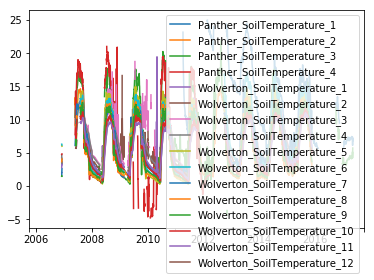

In [71]:
indexUnique = pd.date_range(str(prep.index[0]), str(prep.index[-1]))  
ready_columns = pd.unique(prep.columns)  
siteList = ready_columns
nan_values = np.nan*np.ones([len(indexUnique),len(ready_columns)])
df = pd.DataFrame(nan_values, index=indexUnique, columns = ready_columns) 

plt.figure(figsize=(10,4))
for i in np.arange(len(ready_columns)):  
    print(siteList[i])            
    site = siteList[i]     
    tab = prep[site]

    for j in np.arange(len(prep)): 
        df.loc[tab.index[j]][ready_columns[i]] = tab[j] # 
            
SoilTemperature = copy.deepcopy(df)
SoilTemperature.plot()
SoilTemperature.head(2)

### 13. Isotope

### All result

In [72]:
result = pd.concat([Discharge,Precipitation,AirTemperature,SolarRadiation,RelativeHumidity, 
                    WindDirection,WindSpeed,SnowDepth,
                    SoilMoisture,SoilTemperature],
                    axis=1,
                    join='outer' )
result.index.rename('DateTime',inplace = True)
result.head(2)

ThreeRivers_Discharge  Hammond_Discharge  LodgePole_Discharge  \
DateTime                                                                    
2005-10-01               311.4848           368.1184                  NaN   
2005-10-02               283.1680           368.1184                  NaN   

            Panther_Precipitation  Wolverton_Precipitation  \
DateTime                                                     
2005-10-01                    NaN                      NaN   
2005-10-02                    NaN                      NaN   

            Panther_AirTemperature  Wolverton_AirTemperature  \
DateTime                                                       
2005-10-01                     NaN                       NaN   
2005-10-02                     NaN                       NaN   

            Panther_SolarRadiation  Wolverton_SolarRadiation  \
DateTime                                                       
2005-10-01                     NaN                       NaN   
2005-10-02                     NaN                       NaN   

            Panther_RelativeHumidity  ...  Wolverton_SoilTemperature_3  \
DateTime                              ...                                
2005-10-01                       NaN  ...                          NaN   
2005-10-02                       NaN  ...                          NaN   

            Wolverton_SoilTemperature_4  Wolverton_SoilTemperature_5  \
DateTime                                                               
2005-10-01                          NaN                          NaN   
2005-10-02                          NaN                          NaN   

            Wolverton_SoilTemperature_6  Wolverton_SoilTemperature_7  \
DateTime                                                               
2005-10-01                          NaN                          NaN   
2005-10-02                          NaN                          NaN   

            Wolverton_SoilTemperature_8  Wolverton_SoilTemperature_9  \
DateTime                                                               
2005-10-01                          NaN                          NaN   
2005-10-02                          NaN                          NaN   

            Wolverton_SoilTemperature_10  Wolverton_SoilTemperature_11  \
DateTime                                                                 
2005-10-01                           NaN                           NaN   
2005-10-02                           NaN                           NaN   

            Wolverton_SoilTemperature_12  
DateTime                                  
2005-10-01                           NaN  
2005-10-02                           NaN  

[2 rows x 72 columns]

In [73]:
result.tail(2)

ThreeRivers_Discharge  Hammond_Discharge  LodgePole_Discharge  \
DateTime                                                                    
2017-09-29               594.6528           509.7024            44.457376   
2017-09-30               566.3360           538.0192            39.077184   

            Panther_Precipitation  Wolverton_Precipitation  \
DateTime                                                     
2017-09-29                    NaN                      0.0   
2017-09-30                    NaN                      0.0   

            Panther_AirTemperature  Wolverton_AirTemperature  \
DateTime                                                       
2017-09-29                     NaN                  8.997167   
2017-09-30                     NaN                  7.950917   

            Panther_SolarRadiation  Wolverton_SolarRadiation  \
DateTime                                                       
2017-09-29                     NaN                 35.169708   
2017-09-30                     NaN                 30.009333   

            Panther_RelativeHumidity  ...  Wolverton_SoilTemperature_3  \
DateTime                              ...                                
2017-09-29                       NaN  ...                          NaN   
2017-09-30                       NaN  ...                          NaN   

            Wolverton_SoilTemperature_4  Wolverton_SoilTemperature_5  \
DateTime                                                               
2017-09-29                          NaN                          NaN   
2017-09-30                          NaN                          NaN   

            Wolverton_SoilTemperature_6  Wolverton_SoilTemperature_7  \
DateTime                                                               
2017-09-29                          NaN                          NaN   
2017-09-30                          NaN                          NaN   

            Wolverton_SoilTemperature_8  Wolverton_SoilTemperature_9  \
DateTime                                                               
2017-09-29                          NaN                          NaN   
2017-09-30                          NaN                          NaN   

            Wolverton_SoilTemperature_10  Wolverton_SoilTemperature_11  \
DateTime                                                                 
2017-09-29                           NaN                           NaN   
2017-09-30                           NaN                           NaN   

            Wolverton_SoilTemperature_12  
DateTime                                  
2017-09-29                           NaN  
2017-09-30                           NaN  

[2 rows x 72 columns]

In [74]:
result.columns

Index(['ThreeRivers_Discharge', 'Hammond_Discharge', 'LodgePole_Discharge',
       'Panther_Precipitation', 'Wolverton_Precipitation',
       'Panther_AirTemperature', 'Wolverton_AirTemperature',
       'Panther_SolarRadiation', 'Wolverton_SolarRadiation',
       'Panther_RelativeHumidity', 'Wolverton_RelativeHumidity',
       'Panther_WindDirection', 'Wolverton_WindDirection', 'Panther_WindSpeed',
       'Wolverton_WindSpeed', 'Wolverton_SnowDepth_22',
       'Wolverton_SnowDepth_24', 'Wolverton_SnowDepth_43',
       'Wolverton_SnowDepth_44', 'Wolverton_SnowDepth_11',
       'Wolverton_SnowDepth_12', 'Wolverton_SnowDepth_13',
       'Wolverton_SnowDepth_14', 'Wolverton_SnowDepth_15',
       'Wolverton_SnowDepth_16', 'Wolverton_SnowDepth_21',
       'Wolverton_SnowDepth_23', 'Wolverton_SnowDepth_25',
       'Wolverton_SnowDepth_26', 'Wolverton_SnowDepth_31',
       'Wolverton_SnowDepth_32', 'Wolverton_SnowDepth_33',
       'Wolverton_SnowDepth_34', 'Wolverton_SnowDepth_35',
       'Wol

In [75]:
result.to_csv('1_Wolverton_Download_Aggregation_Daily.csv', sep=',')